In [2]:
# Installing the latest gluonts
!pip install gluonts


In [3]:
!unzip /content/lag-llama.zip #Unzip the ziped file

Archive:  /content/lag-llama.zip
replace lag-llama/.git/config? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import sys
import os

# Assuming 'lag_llama' is directly in the root directory of the Colab environment
sys.path.append('/content/lag-llama/lag_llama/gluon') #this method is used to add a new directory to the list of paths in 'sys.path.'

In [5]:
!pip install pytorch_lightning

In [1]:
!pip install -r /content/lag-llama/requirements.txt

In [6]:
import sys
import os

# Add the directory containing 'lag_llama' to the Python path
sys.path.append('/content/lag-llama')

In [7]:
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import pandas as pd
from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-7-84776248e911>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [28]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    # Load the model checkpoint from the specified path, maping it to the correct device (CPU or GPU)
    ckpt = torch.load("/content/lag-llama/lag-llama.ckpt", map_location=device)
    # extract the hyperparameters and model arguments from the checkpoint
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    # Initialize the LagLlamaEstimator with the parameters and arguments from the checkpoint
    estimator = LagLlamaEstimator(
        ckpt_path="/content/lag-llama/lag-llama.ckpt",# Path to the model checkpoint
        prediction_length=prediction_length,# Length of the prediction window
        context_length=context_length,# Length of the context window

        # estimator args
        input_size=estimator_args["input_size"],# Input size for the model
        n_layer=estimator_args["n_layer"],# Number of layers in the model
        n_embd_per_head=estimator_args["n_embd_per_head"],# Number of embeddings per head
        n_head=estimator_args["n_head"], # Number of heads in the model
        scaling=estimator_args["scaling"],# Scaling factor
        time_feat=estimator_args["time_feat"],# Time features used by the model

        nonnegative_pred_samples=nonnegative_pred_samples,# Ensure non-negative prediction samples

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),# Scaling factor for positional encoding
        },

        batch_size=batch_size,# Batch size for predictions
        num_parallel_samples=num_samples,# Number of parallel samples to generate
    )

    lightning_module = estimator.create_lightning_module()  # Create a LightningModule for model training and inference
    transformation = estimator.create_transformation()  # Create a data transformation pipeline for preprocessing the input data
    predictor = estimator.create_predictor(transformation, lightning_module)
    # Generate predictions using the predictor on the provided dataset
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,# Input dataset
        predictor=predictor,# Predictor created from the estimator
        num_samples=num_samples # Number of prediction samples to generate
    )
    # Convert the forecast and ground truth iterators to lists, with progress bars
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss   # Return the forecasts and the ground truth time series values


In [56]:
# Preprocess the NASA Turbofan dataset
# Define column names for the dataset
index_names = ['unit_nr', 'time_cycles']    # Identifiers for unit number and time cycles
setting_names = ['setting_1', 'setting_2', 'setting_3'] # Operational settings
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] # Sensor measurements s_1 to s_21
col_names = index_names + setting_names + sensor_names  # Combined column names

# Read data
train = pd.read_csv('/content/lag-llama/train_FD001.txt', sep='\s+', header=None, names=col_names)
drop_sensors = ['s_5', 's_16' , 's_19'] # Define sensors to drop
# Define columns to drop (settings and selected sensors)
drop_labels = setting_names + drop_sensors + ['time_cycles']

# Filter the data to retain sensor columns
data = train.drop(drop_labels, axis=1)

# Create GluonTS dataset for each sensor
datasets = {}   # Dictionary to hold datasets for each sensor
for sensor in data.columns[1:]:  # Skip 'unit_nr'
    timeseries = [] # List to hold time series data for the current sensor
    # Group the data by 'unit_nr' (each unit's data is treated separately)
    for unit_nr, group in data.groupby('unit_nr'):
        target_values = group[sensor].tolist()  # Convert sensor data to a list
        # Create a dictionary for each time series with target values and a dummy start date
        timeseries.append({
            FieldName.TARGET: target_values,
            FieldName.START: pd.Timestamp("2020-01-01")  # Dummy start date
        })
    datasets[sensor] = ListDataset(timeseries, freq='1D')   # Create a ListDataset object for the current sensor
    #Assign one of the datasets to the variable 'dataset'
    dataset = datasets['s_1']


In [57]:
# Define the rest of the parameters

prediction_length = 30  # Example, adjust as necessary
context_length = prediction_length * 3  # Length of the context window used for making predictions
num_samples = 20    # Number of samples to generate for each prediction
device = "cuda" # Device to run the model on


forecasts, tss = get_lag_llama_predictions(
    dataset=dataset,    # Input dataset
    prediction_length=prediction_length,    # Number of future time steps to predict
    num_samples=num_samples,     # Number of samples to generate for each prediction
    context_length=context_length,  # Length of the context window
    device=device   # Device to run the model on
)

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_1, series 1: [518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67]
Predictions for sensor s_1, series 2: [518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67]
Predictions for sensor s_1, series 3: [518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67]
Predictions for sensor s_1, series 4: [518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67
 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 518.67 

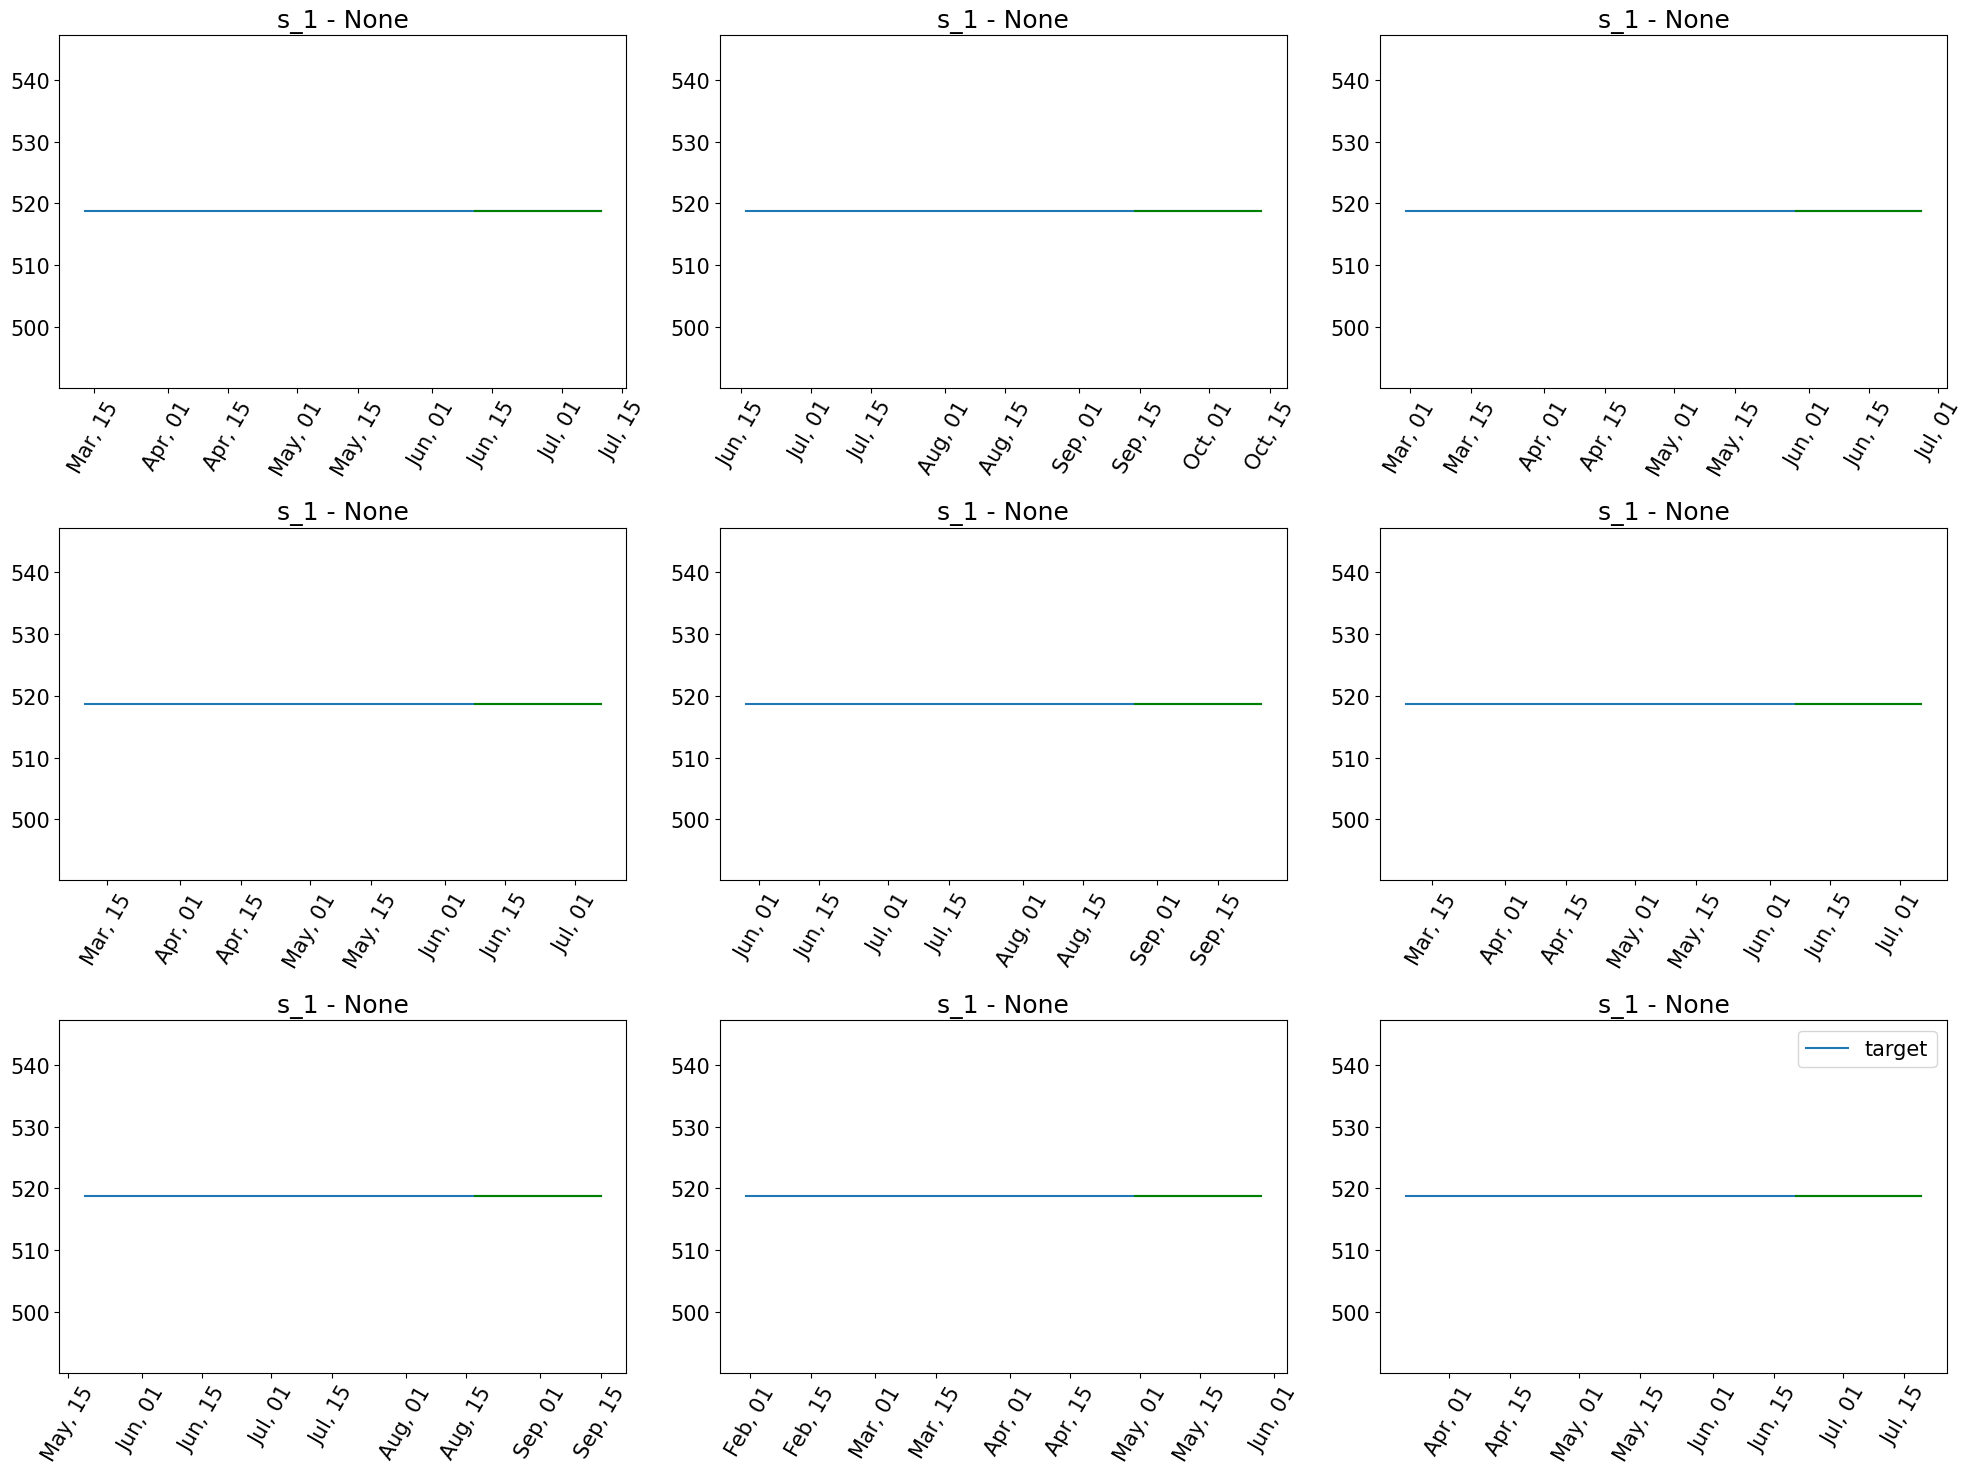

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_2, series 1: [642.243   642.18317 642.1588  641.5401  642.8852  641.40686 642.10254
 643.2353  641.9352  642.5848  641.8645  643.0562  642.7937  642.9813
 642.72723 639.81836 642.28107 643.59863 643.9752  642.9505  642.00964
 641.1196  642.5084  642.6258  641.404   642.59436 641.6979  641.9684
 641.6559  641.6234 ]
Predictions for sensor s_2, series 2: [642.69073 640.24335 640.558   644.4187  643.6045  642.21405 641.42365
 643.61646 644.3681  640.98987 642.5103  641.2239  642.04584 643.11536
 641.7987  642.63324 642.30054 640.2842  642.27704 642.2979  643.0355
 642.0292  644.42896 640.6991  642.93896 642.0528  642.2549  642.4229
 643.2271  640.60315]
Predictions for sensor s_2, series 3: [643.7496  642.7619  643.02234 643.7958  641.9614  642.51294 642.99664
 641.3443  642.30084 642.4811  642.9199  641.66174 640.8045  642.00104
 641.36505 642.78784 643.4195  642.4415  642.91675 642.4864  643.4875
 642.62506 642.53015 643.64124 642.8383  643.6195  643.143   641.5

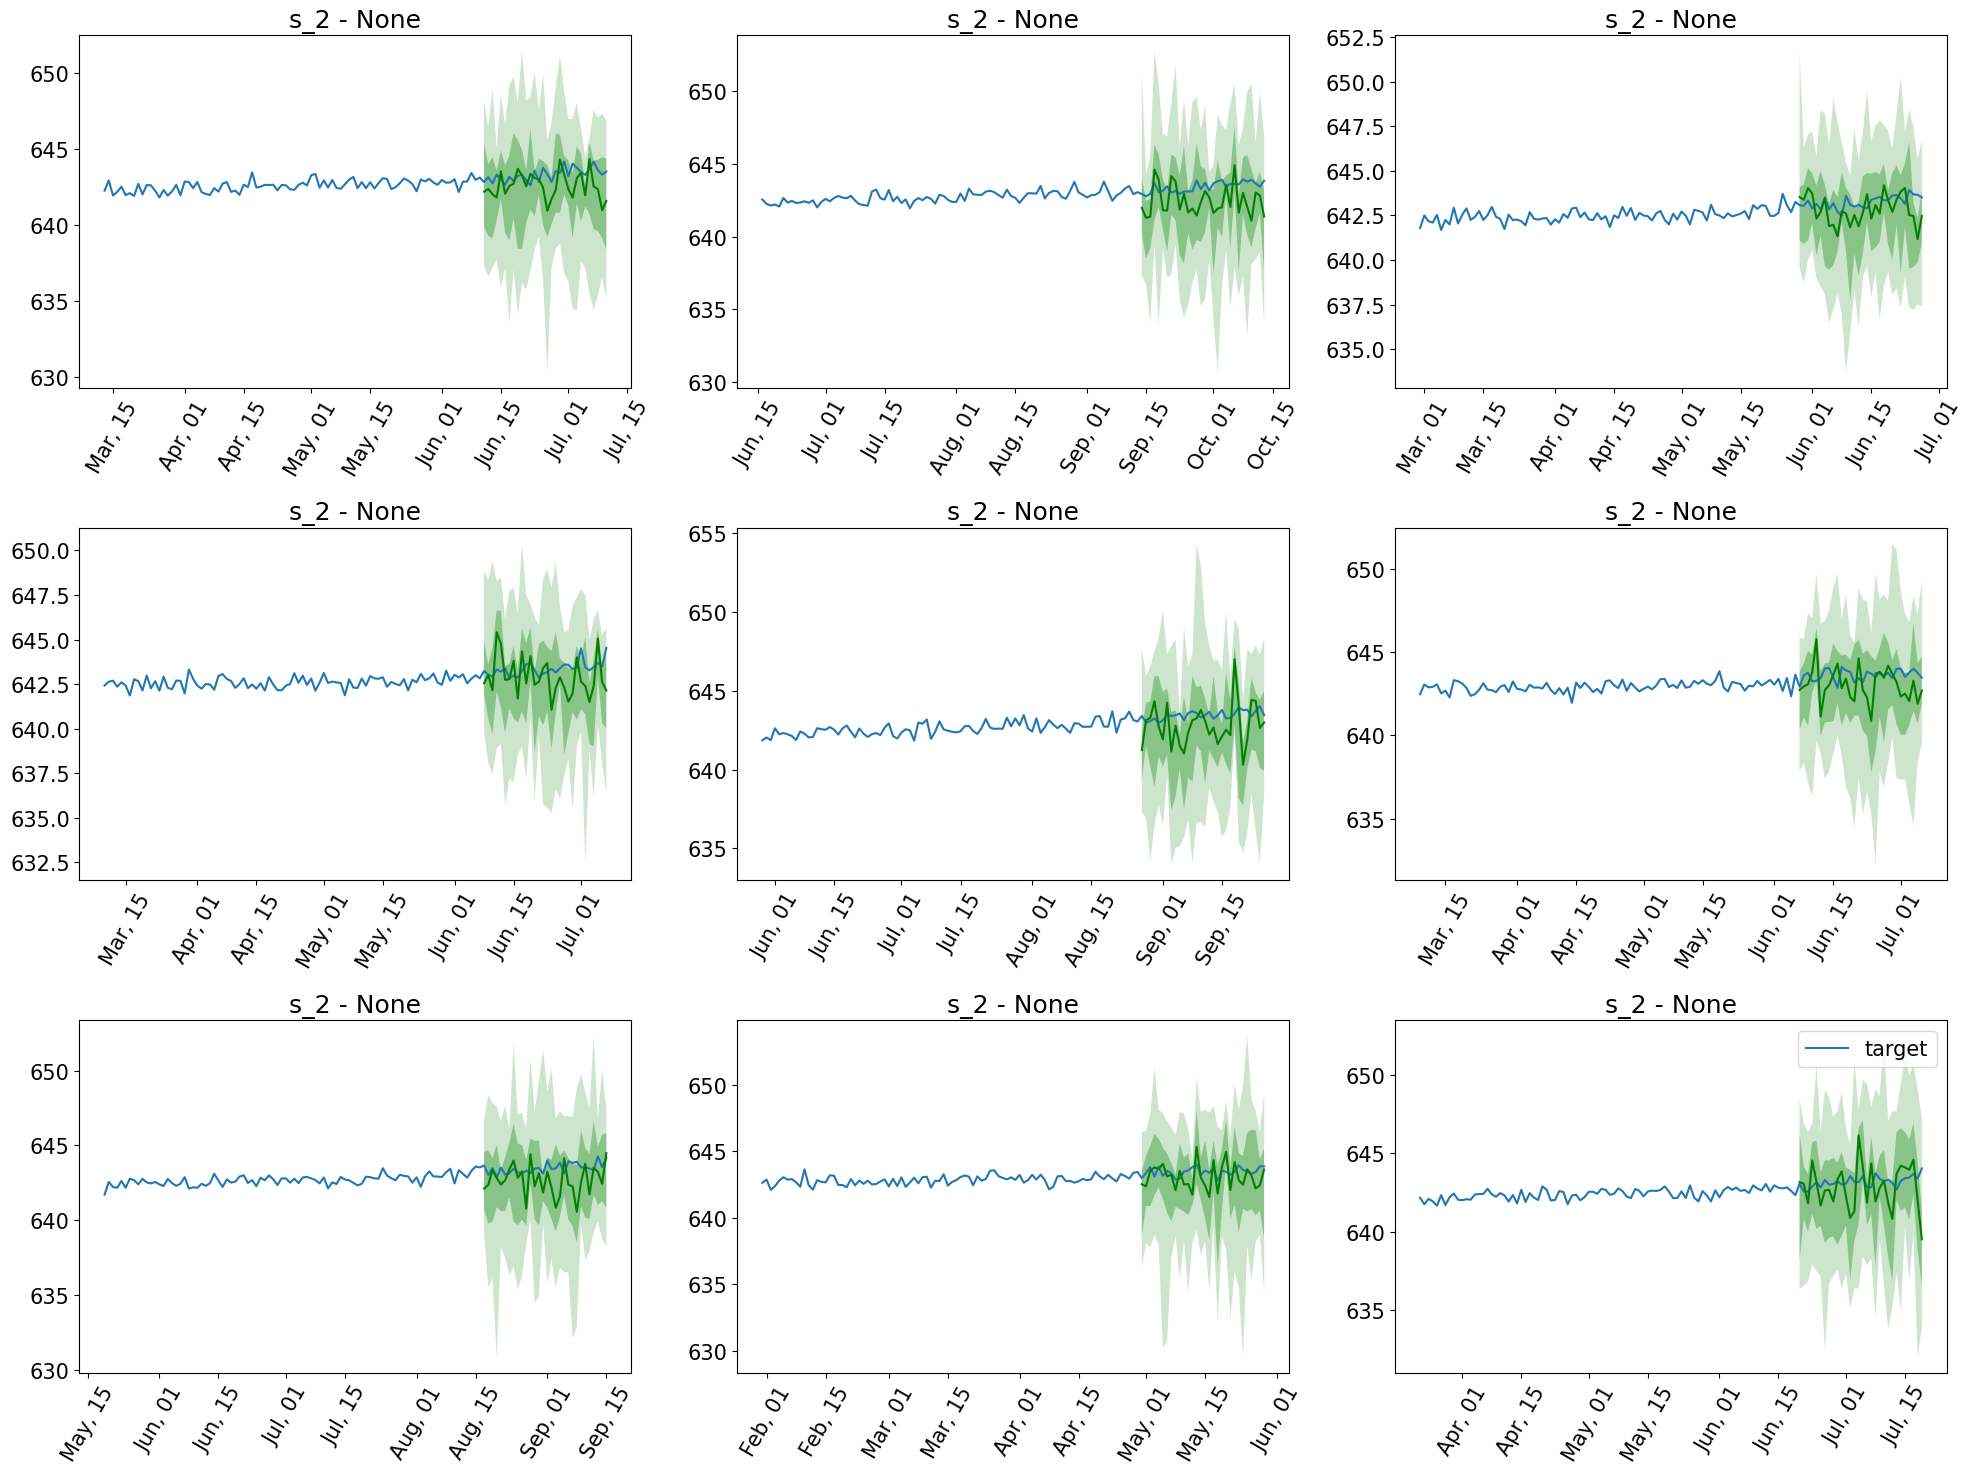

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_3, series 1: [1593.4199 1577.3254 1591.1096 1590.1853 1587.371  1591.0238 1600.9749
 1592.0204 1593.2854 1575.8334 1596.5979 1596.0969 1608.9343 1582.2574
 1588.9922 1586.6051 1593.2997 1594.7588 1576.7881 1585.9708 1585.3738
 1605.5359 1590.0157 1596.782  1612.146  1619.2552 1595.6711 1582.1235
 1592.1041 1586.9668]
Predictions for sensor s_3, series 2: [1590.6276 1603.3962 1583.5547 1598.175  1603.3801 1595.2805 1603.498
 1585.6846 1582.1893 1595.8724 1576.3616 1593.4304 1582.7727 1599.4117
 1583.7041 1586.4644 1589.0331 1586.6658 1579.1176 1566.7434 1592.7068
 1601.8811 1585.6267 1602.0732 1587.0895 1584.261  1576.3394 1593.063
 1592.0739 1585.6843]
Predictions for sensor s_3, series 3: [1581.7035 1587.2214 1587.2843 1567.5442 1578.5619 1575.6967 1591.6389
 1593.9758 1584.5754 1592.8822 1586.928  1598.7458 1581.8193 1573.817
 1565.3263 1583.4594 1604.1326 1588.1252 1590.0237 1599.7622 1588.6462
 1589.6791 1618.8468 1591.0559 1601.9597 1578.8058 1582.8636 158

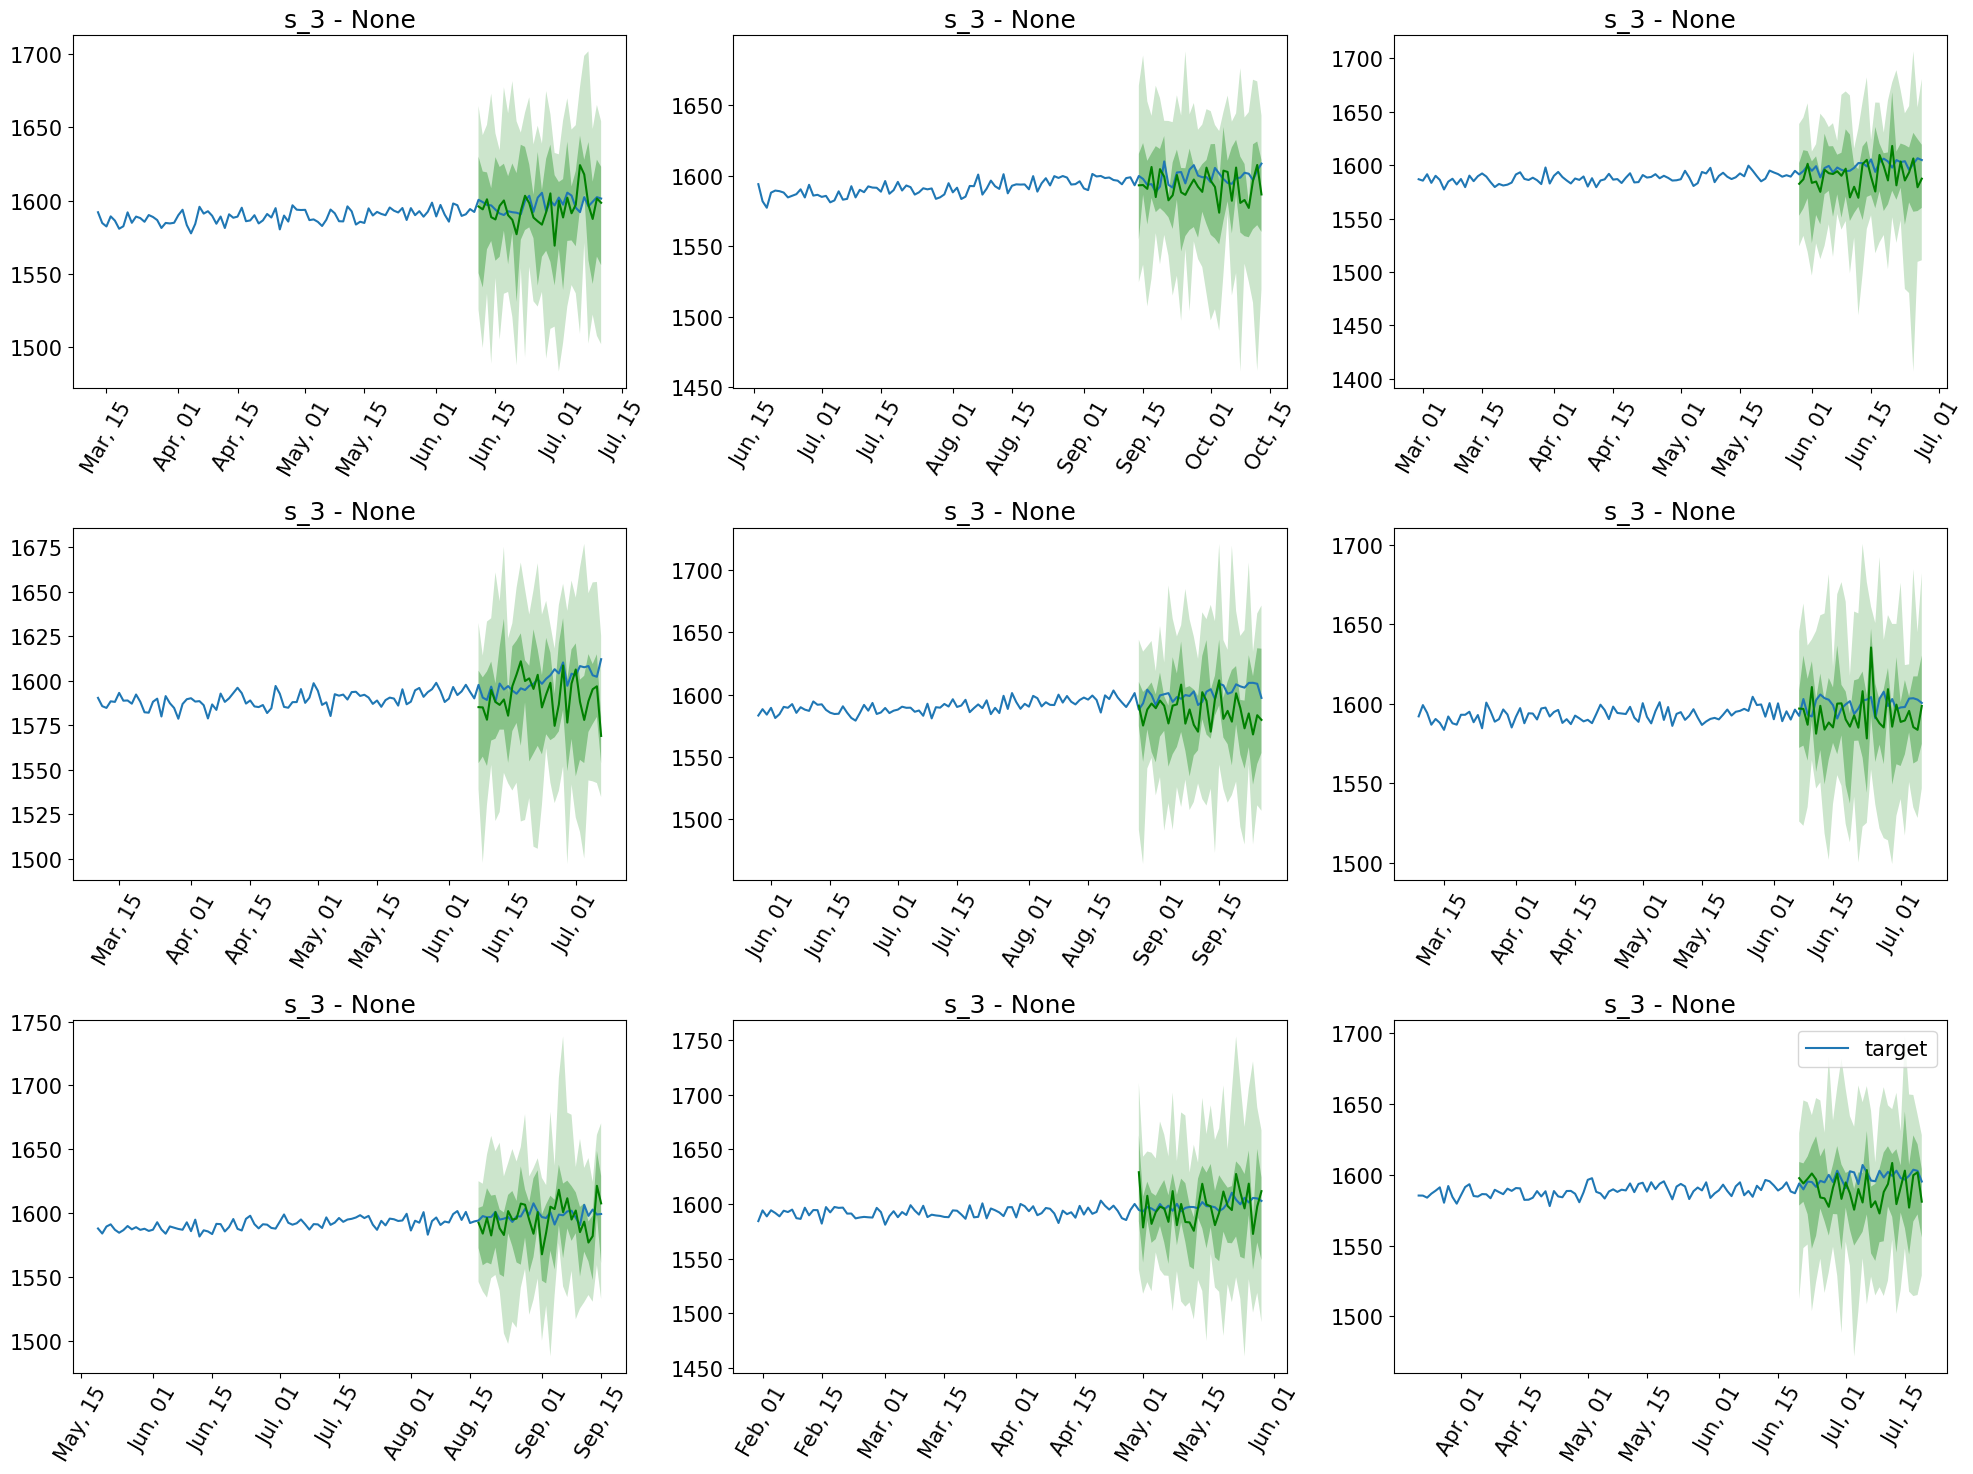

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_4, series 1: [1385.3444 1408.9841 1397.1868 1387.5778 1406.8915 1426.7996 1420.8595
 1384.0632 1407.7322 1423.1155 1401.5681 1418.4146 1389.9983 1396.6115
 1416.2197 1401.0232 1385.8256 1392.7317 1406.0613 1411.0928 1411.8896
 1410.9075 1401.788  1392.6578 1411.6743 1394.2972 1396.5889 1391.2615
 1393.7046 1416.8782]
Predictions for sensor s_4, series 2: [1405.0007 1384.6423 1390.9001 1407.543  1384.1111 1422.3563 1383.4144
 1382.0242 1394.9879 1407.3678 1411.8214 1381.2148 1386.1884 1383.2384
 1424.0574 1415.5535 1405.6462 1388.8049 1410.2073 1383.2968 1408.8523
 1416.5483 1422.4336 1382.8075 1401.6996 1409.9366 1410.5125 1407.9104
 1391.7036 1379.9501]
Predictions for sensor s_4, series 3: [1430.8239 1414.0875 1403.8489 1415.4412 1395.6726 1411.5178 1396.8259
 1388.0652 1406.0663 1402.3435 1413.0754 1413.8171 1412.655  1398.9059
 1385.654  1403.9156 1409.4672 1419.5928 1390.5936 1399.0095 1402.3162
 1404.4309 1383.1472 1398.9166 1427.8225 1411.4542 1380.5583 

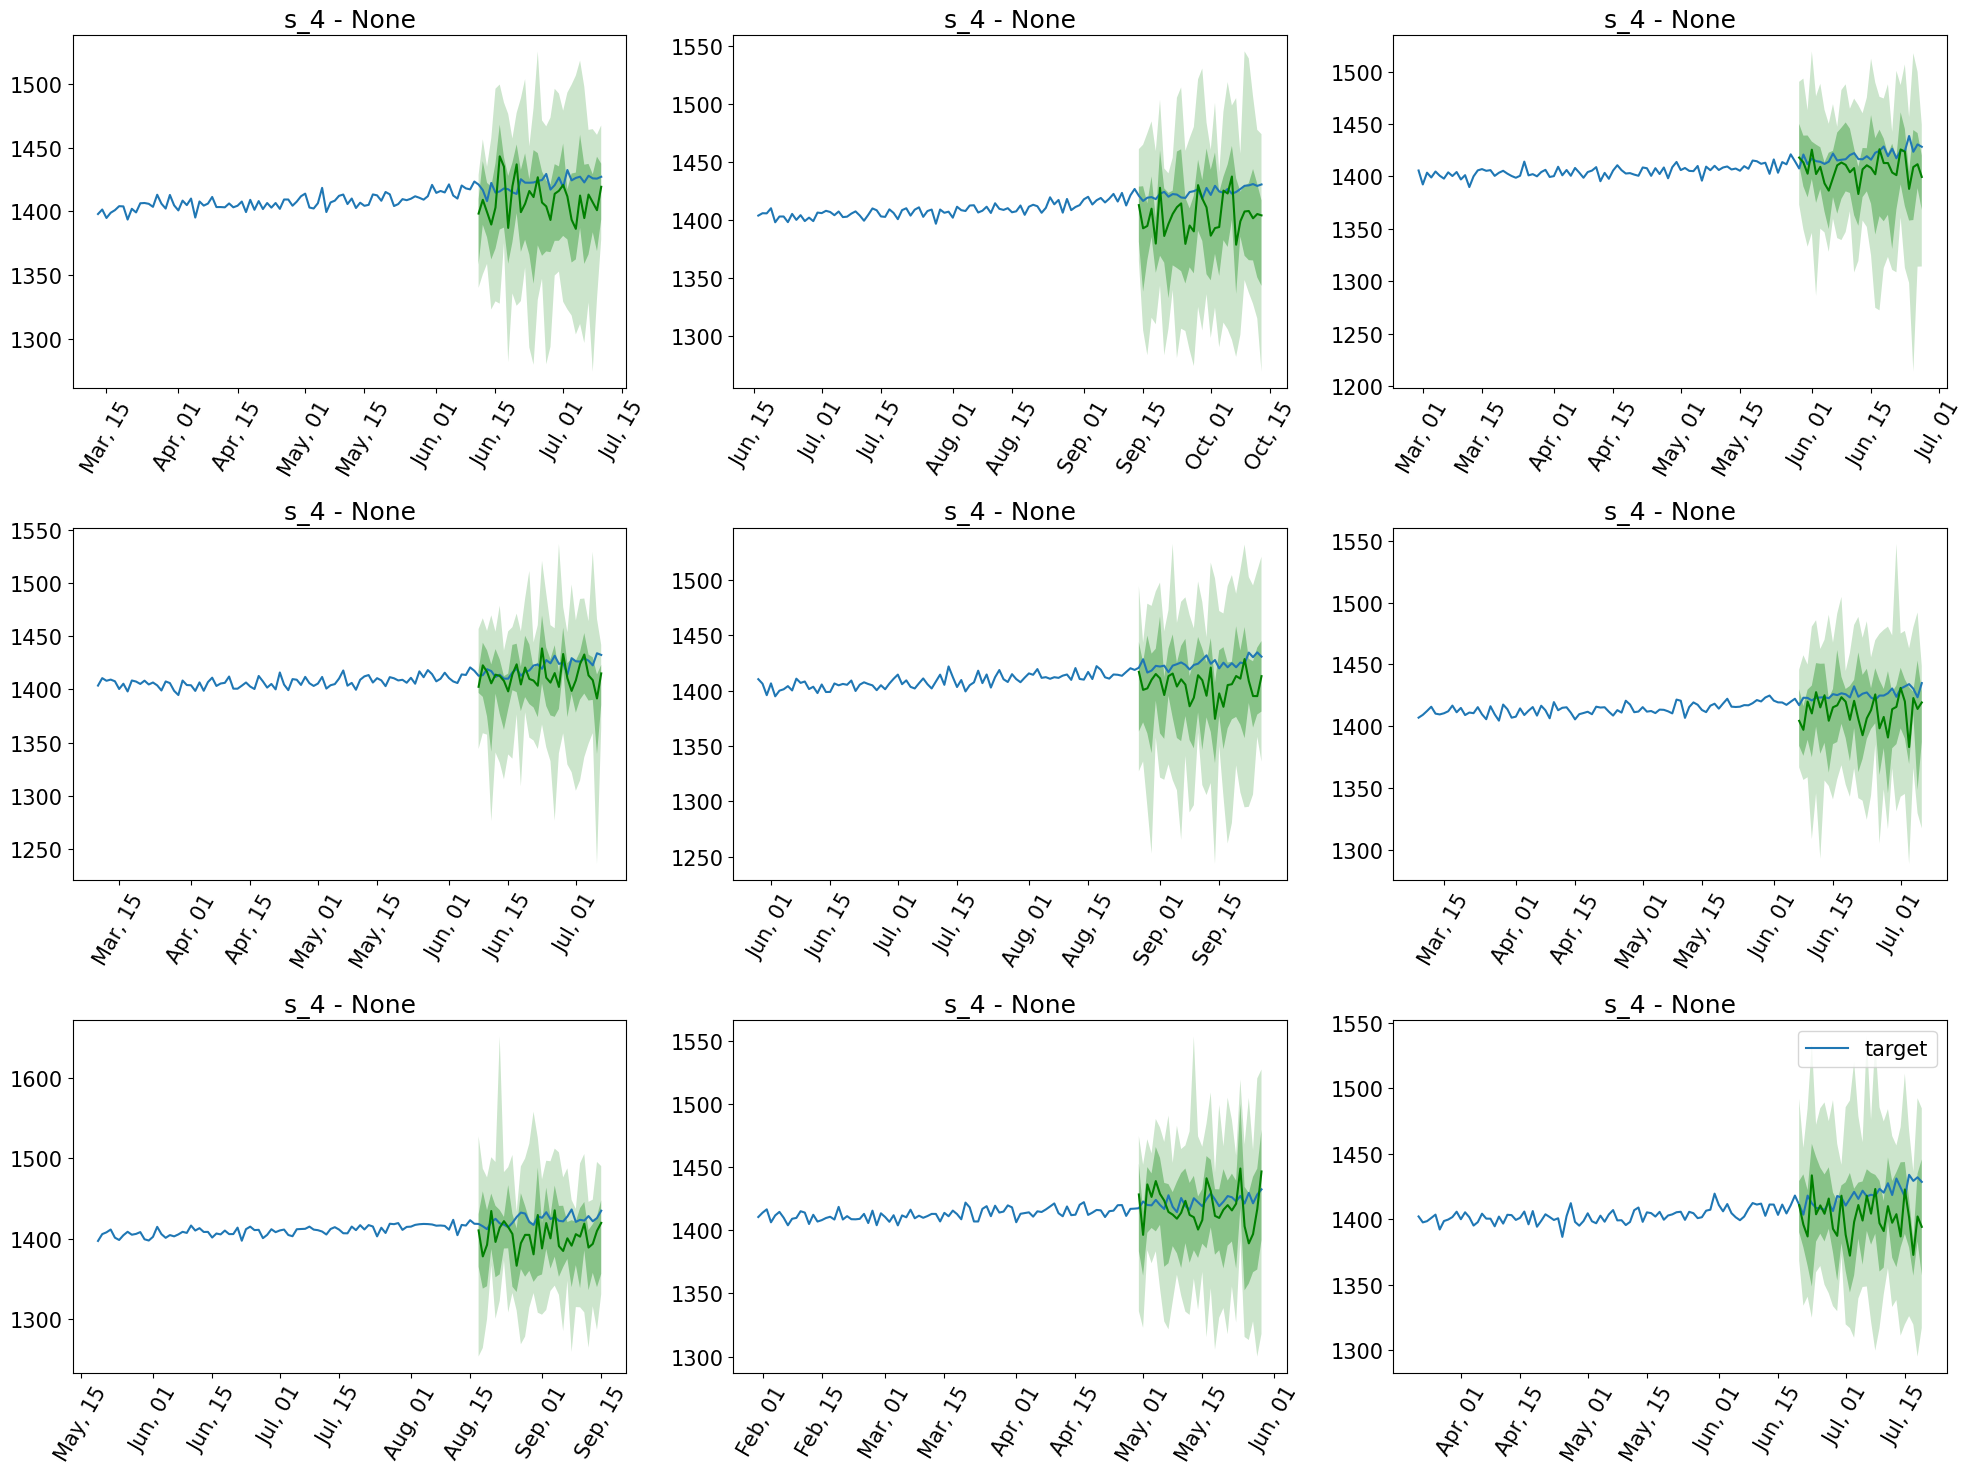

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_6, series 1: [21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995]
Predictions for sensor s_6, series 2: [21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995]
Predictions for sensor s_6, series 3: [21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995
 21.609995 21.609995 21.609995 21.609995 21.609995 21.609995 

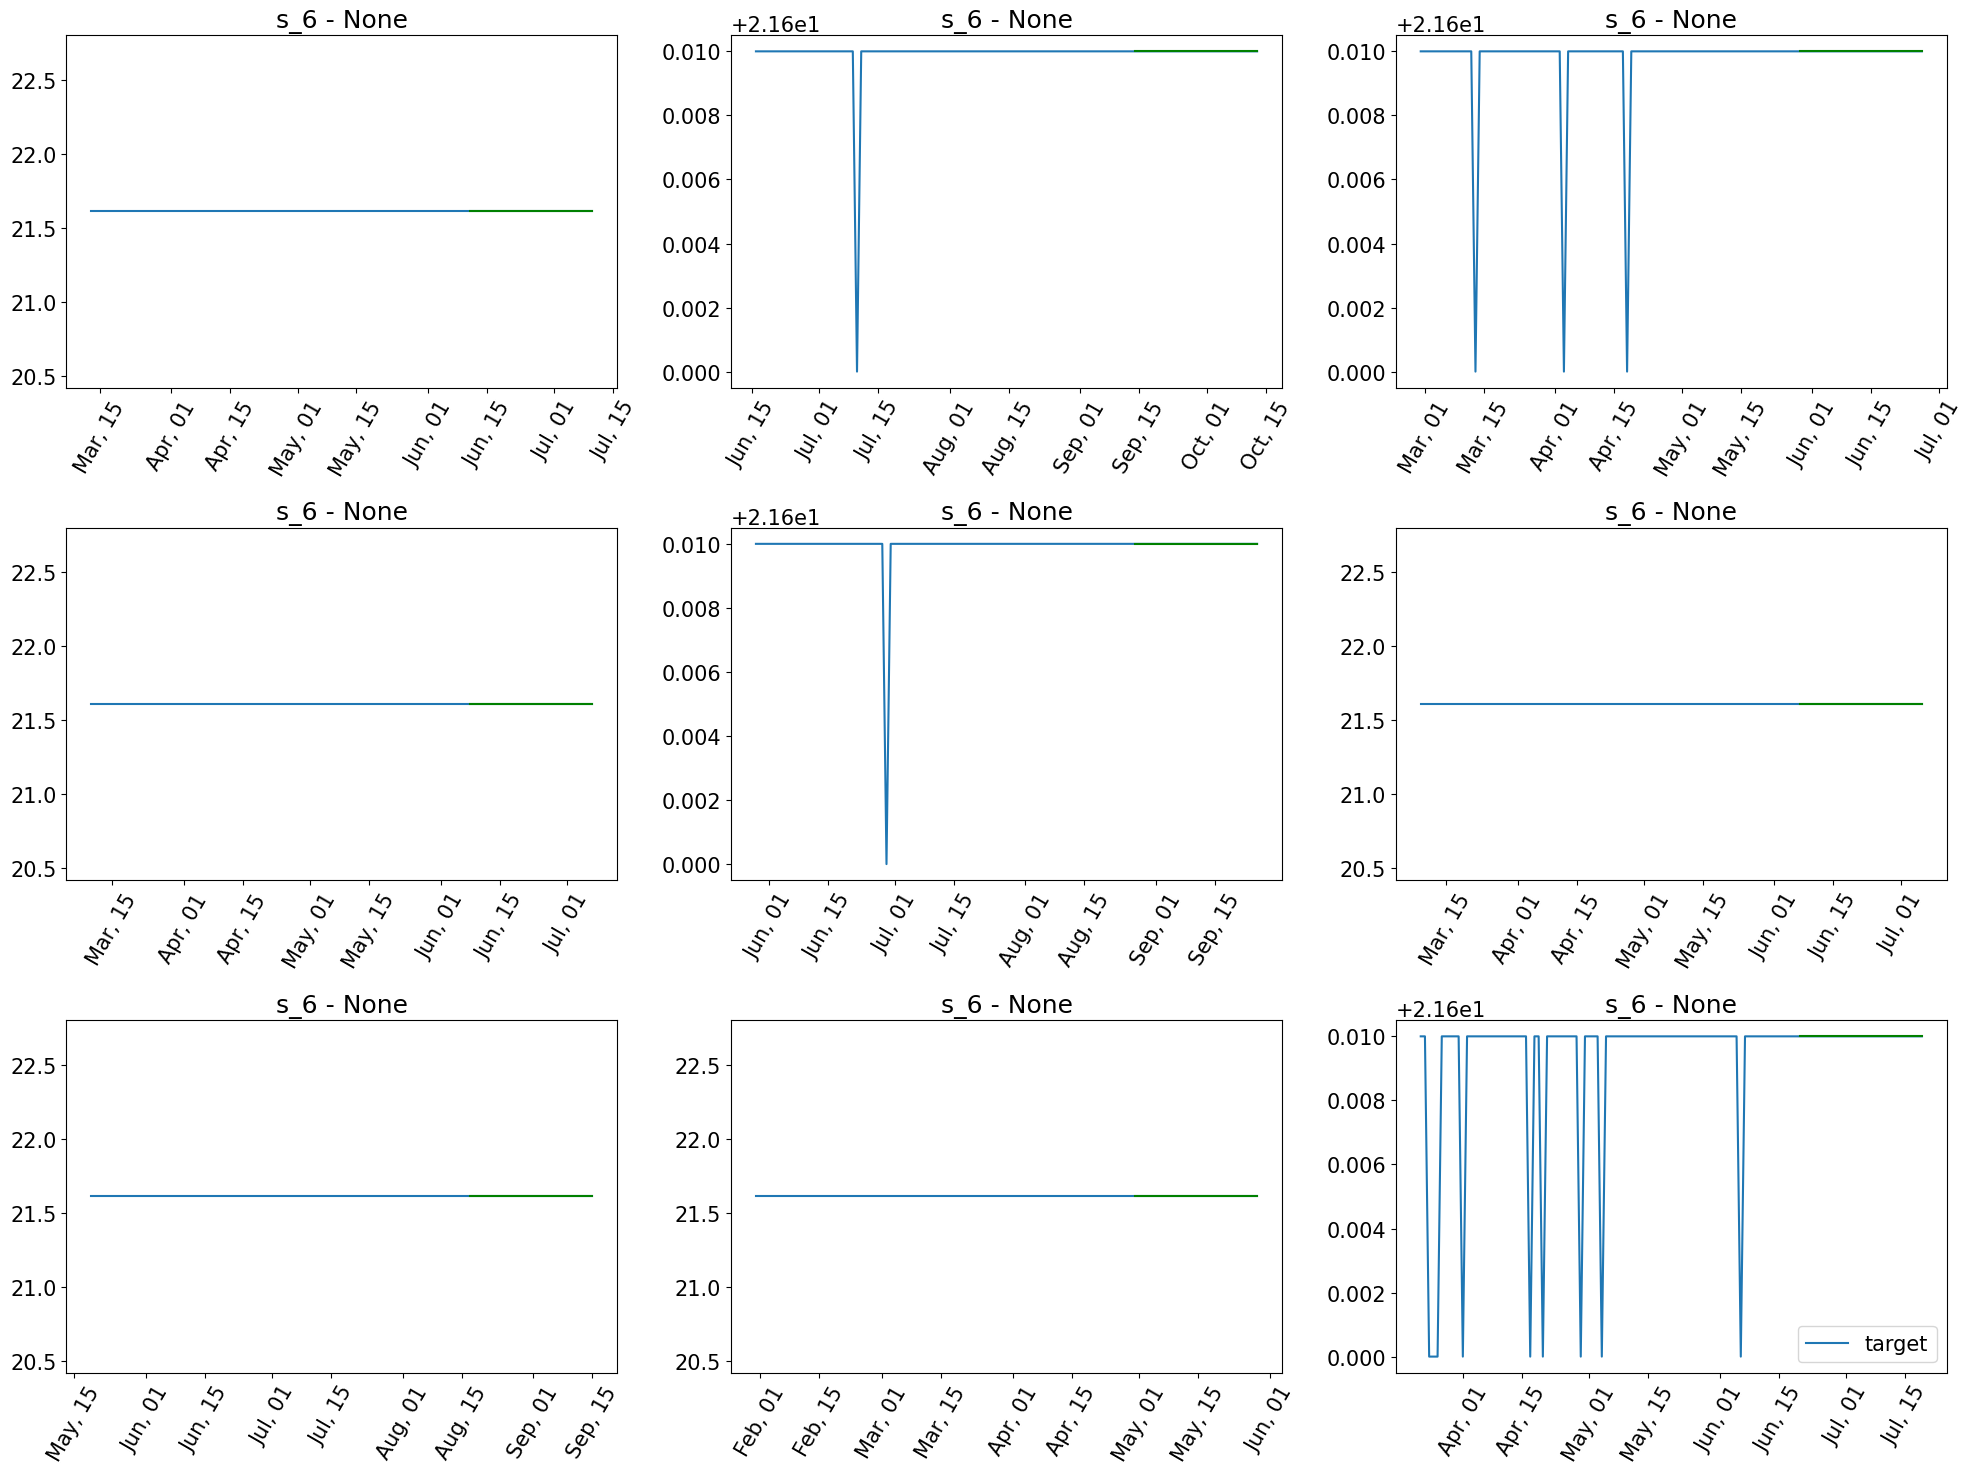

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_7, series 1: [553.0589  553.1447  553.2061  552.6481  554.3334  553.3087  551.46106
 551.47235 554.4813  554.9247  553.3606  554.7677  557.1546  553.1483
 552.285   555.3434  555.676   554.2521  556.1786  552.8309  554.6263
 553.7898  554.40515 552.9169  553.3835  553.33923 553.3749  554.54407
 554.555   554.73254]
Predictions for sensor s_7, series 2: [554.79456 555.0597  553.6691  553.7457  552.67255 553.62933 553.8178
 553.42456 555.9747  554.0203  553.6929  553.7894  554.0142  553.3813
 553.40796 551.32526 554.76324 555.7292  552.7389  554.81433 554.8517
 555.37463 556.1065  554.3017  555.1239  553.3888  554.91144 553.8801
 555.71606 554.56555]
Predictions for sensor s_7, series 3: [553.31824 556.1474  553.25555 553.0524  553.8829  554.7421  553.82916
 555.5056  554.0338  555.1074  553.9779  554.1579  556.2549  553.8002
 554.4132  555.68207 555.5109  554.5875  553.82965 555.84973 555.77484
 551.54913 550.87286 553.1317  554.7019  554.78186 555.71936 555.173

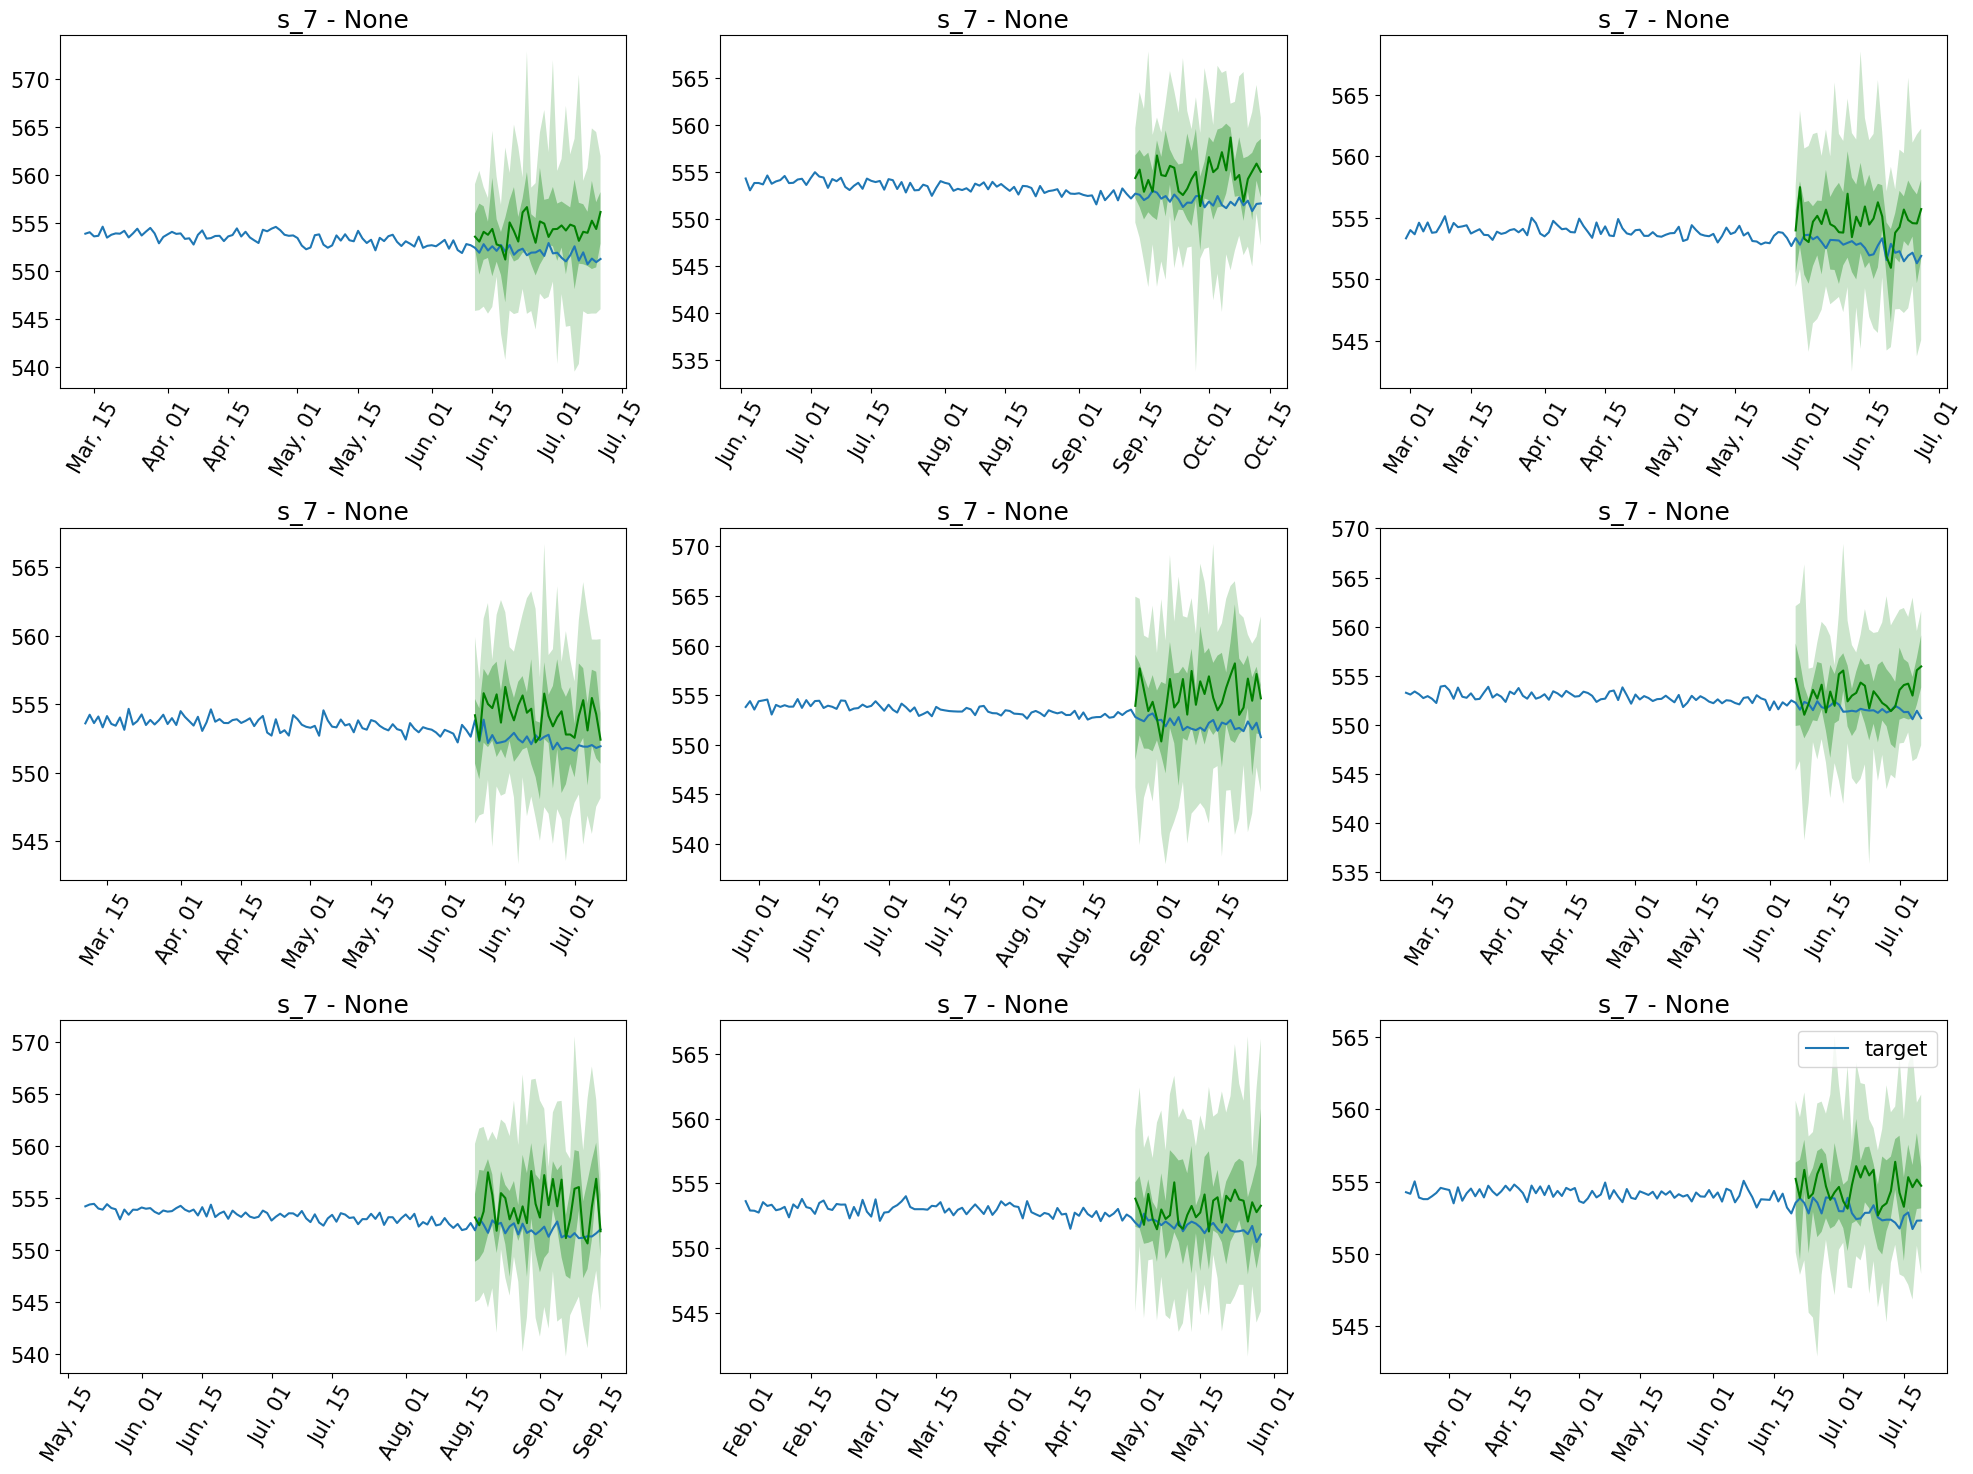

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_8, series 1: [2387.9631 2388.0361 2388.104  2387.9958 2388.191  2388.051  2388.1697
 2387.906  2388.3276 2388.0964 2388.0266 2388.0386 2387.9934 2388.1138
 2387.8975 2388.219  2388.3513 2388.1924 2388.1567 2388.1194 2387.8513
 2388.0854 2388.2886 2388.0757 2388.0642 2388.1577 2388.1672 2388.291
 2387.984  2387.9731]
Predictions for sensor s_8, series 2: [2388.1646 2387.9065 2387.859  2388.022  2388.0576 2388.101  2387.8013
 2388.2212 2388.1047 2388.0874 2388.     2387.9985 2388.2065 2388.012
 2387.8853 2387.902  2388.1626 2388.1033 2387.9946 2387.877  2388.186
 2387.9448 2387.952  2387.871  2388.2651 2387.978  2387.9517 2388.128
 2387.8374 2387.989 ]
Predictions for sensor s_8, series 3: [2388.1567 2388.0776 2388.0513 2388.012  2388.0015 2387.9944 2388.0664
 2388.0476 2388.066  2388.089  2388.17   2388.0688 2388.023  2388.059
 2388.016  2387.9146 2387.9302 2388.0706 2388.063  2388.0256 2388.0583
 2388.0776 2388.0774 2388.0132 2388.0708 2387.9539 2387.9634 2387.

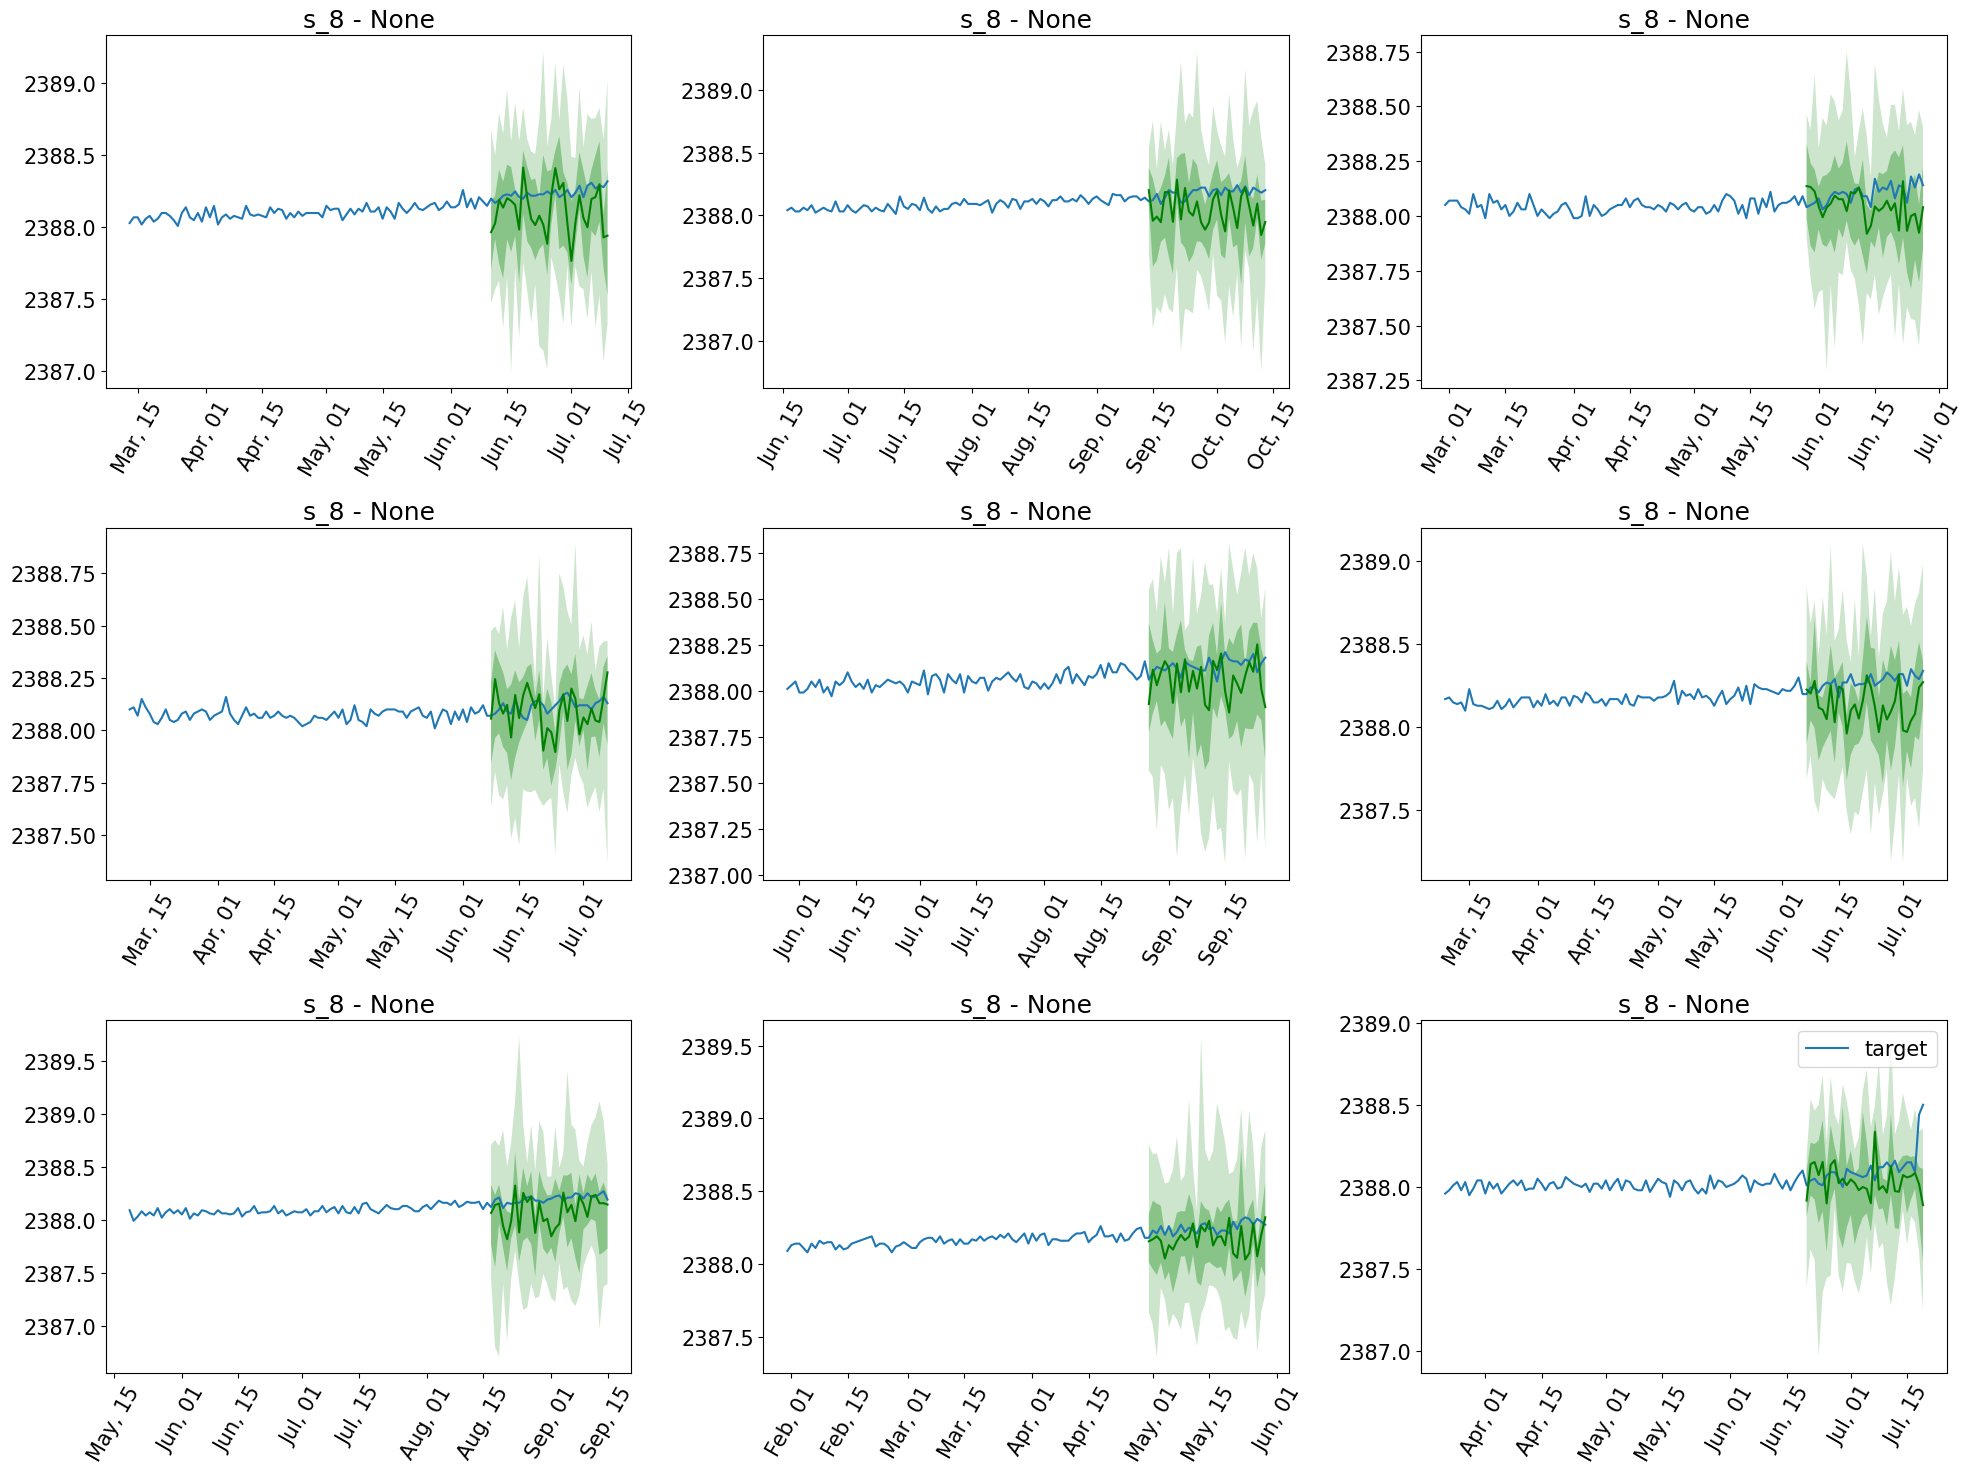

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_9, series 1: [9060.4   9044.277 9051.136 9060.971 9052.584 9043.65  9068.728 9039.447
 9039.508 9046.158 9047.169 9052.316 9041.523 9049.978 9065.795 9046.125
 9048.581 9041.707 9049.397 9068.792 9045.987 9046.033 9058.017 9043.28
 9056.198 9044.38  9052.024 9046.855 9038.896 9044.227]
Predictions for sensor s_9, series 2: [9023.586 9089.939 9063.758 9044.65  9051.526 9049.775 9055.531 9057.267
 9063.68  9063.622 9088.275 9060.416 9059.479 9056.74  9045.859 9052.074
 9053.273 9050.724 9083.302 9024.307 9051.911 9070.342 9052.932 9058.572
 9067.478 9075.861 9050.693 9067.068 9037.42  9078.937]
Predictions for sensor s_9, series 3: [9032.322 9060.868 9053.92  9037.938 9036.632 9055.748 9115.229 9060.323
 9095.383 9058.672 9089.612 9060.252 9052.817 9027.366 9062.385 9079.443
 9046.638 9090.764 9048.068 9074.639 9043.486 9053.485 9036.049 9019.197
 9025.203 9060.401 9063.748 9009.062 9023.467 9079.253]
Predictions for sensor s_9, series 4: [9026.663 9116.645 9041.

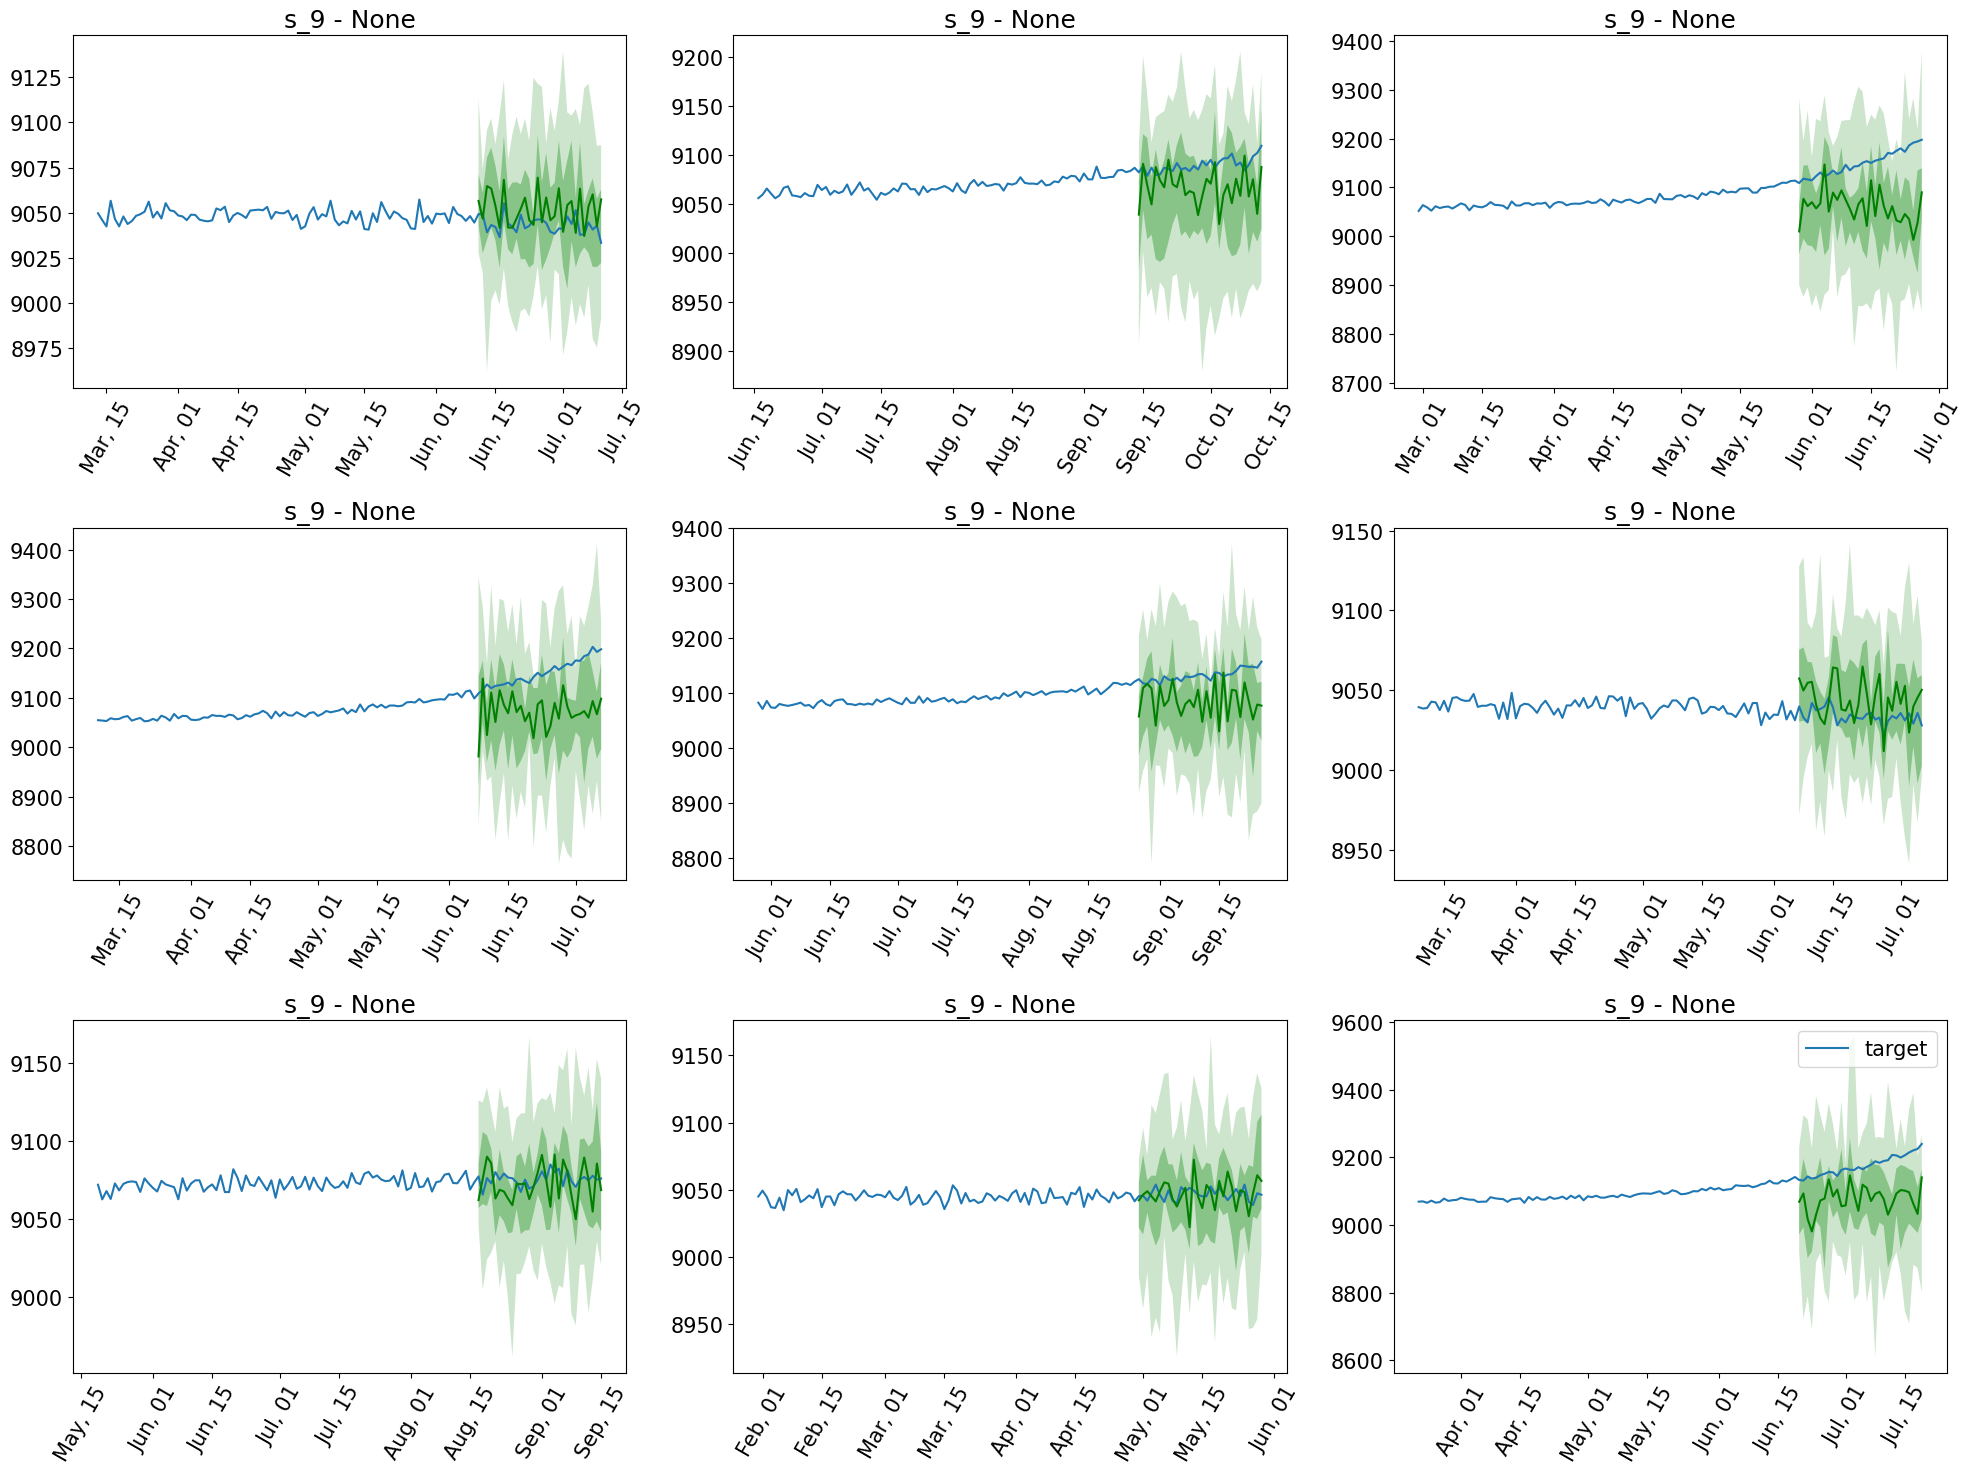

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_10, series 1: [1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998]
Predictions for sensor s_10, series 2: [1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998]
Predictions for sensor s_10, series 3: [1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998
 1.2999998 1.2999998 1.2999998 1.2999998 1.2999998 1.29999

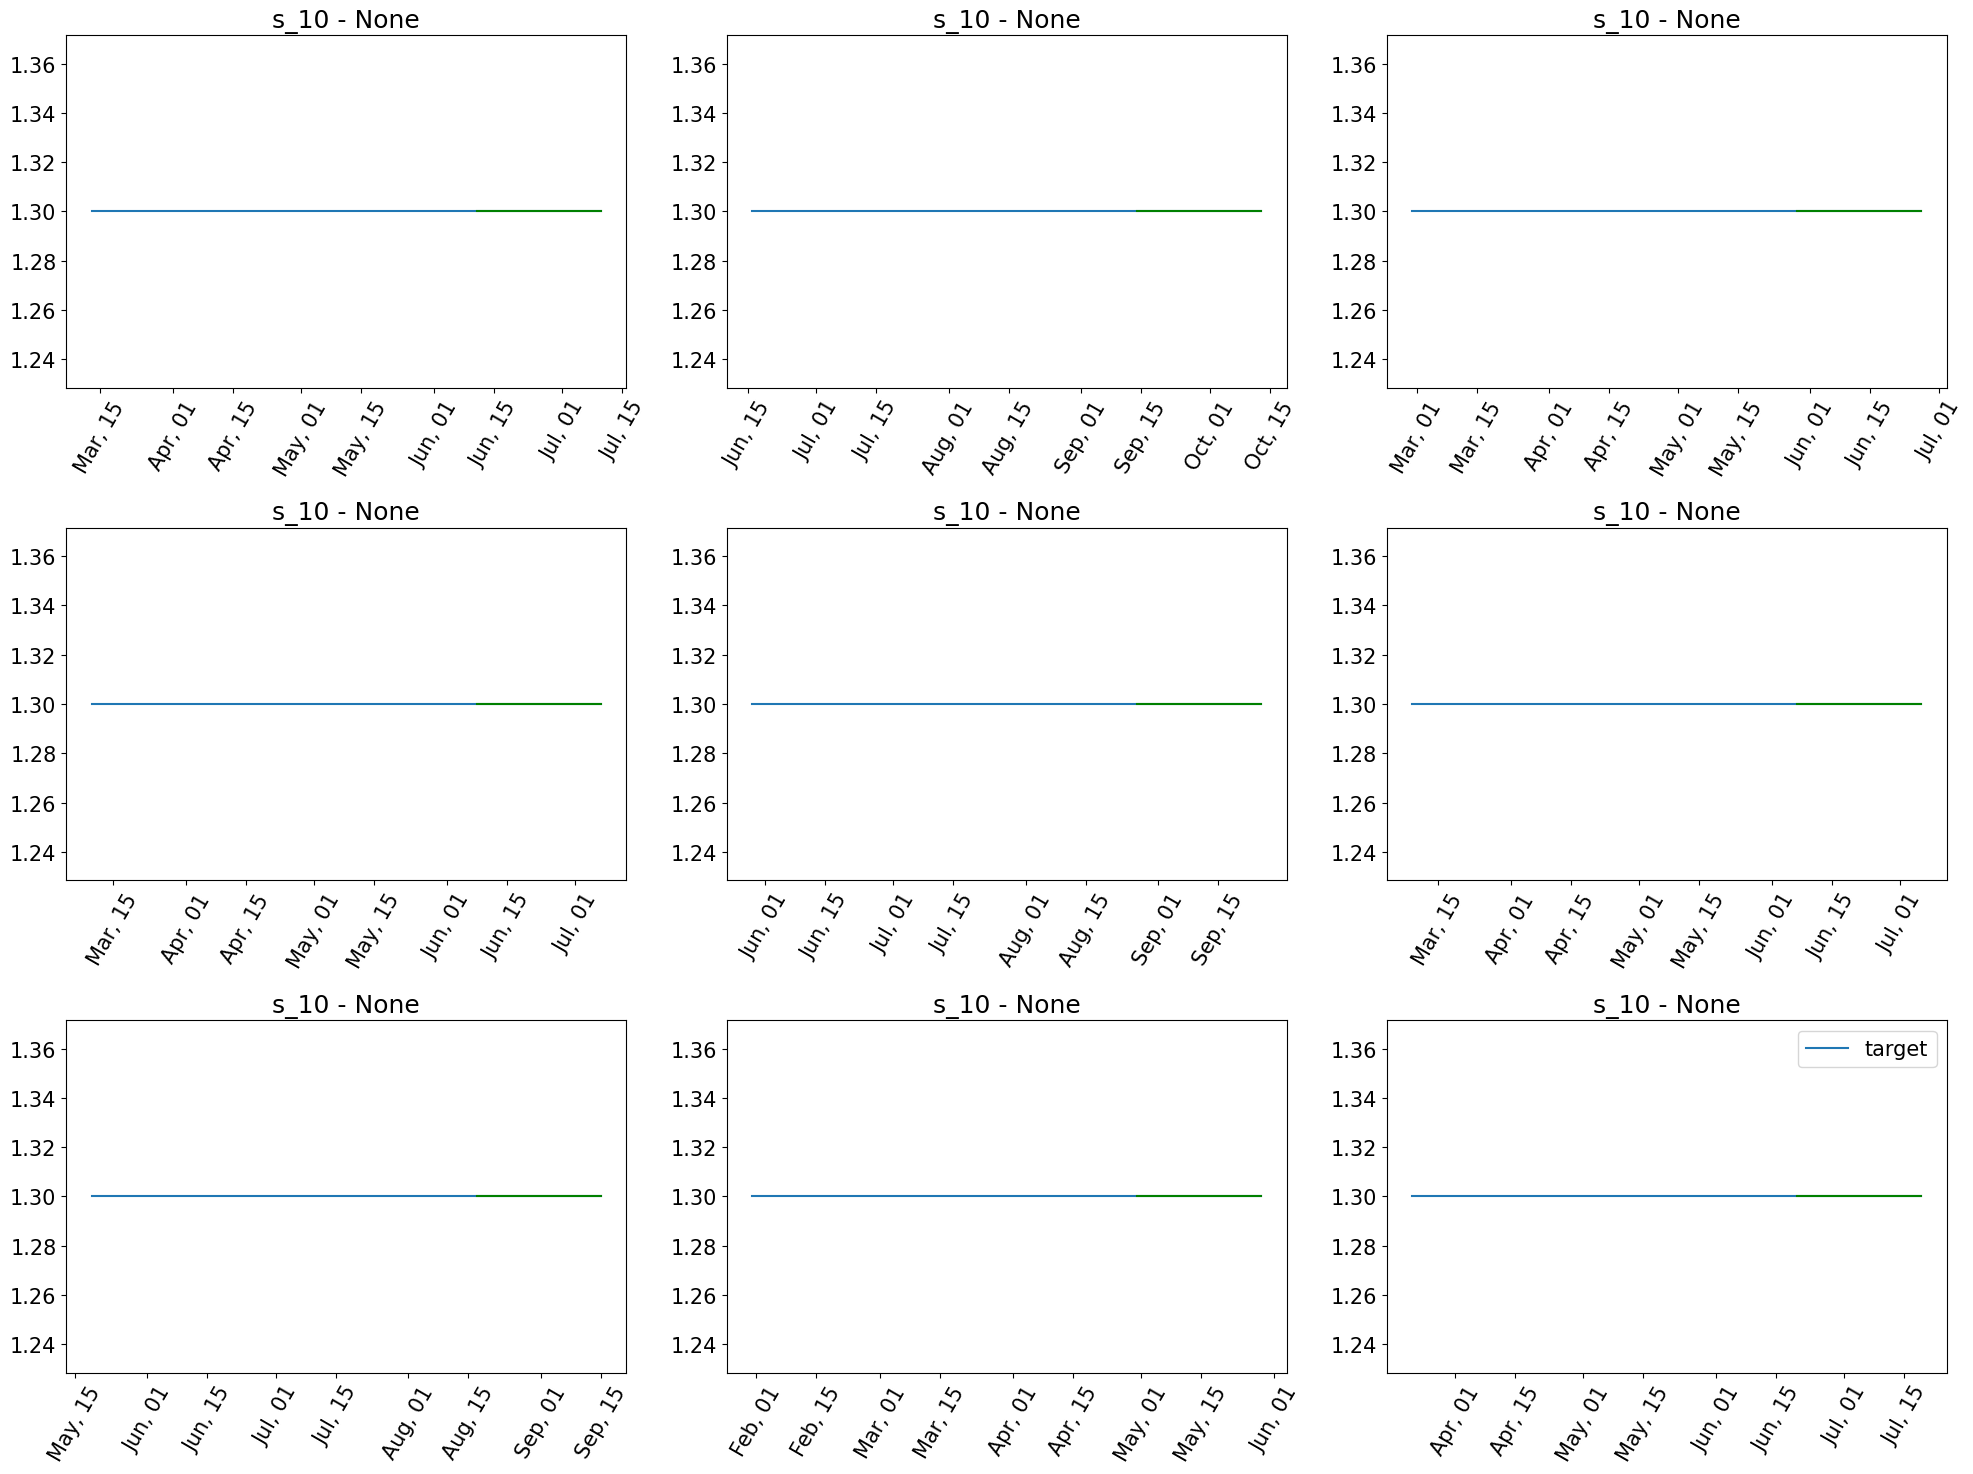

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_11, series 1: [47.129974 47.604107 47.39365  47.174923 47.55921  48.153164 46.242912
 47.004498 47.205914 48.151134 48.02783  47.372177 47.411556 47.643204
 47.235336 47.39513  48.86081  47.296635 47.123238 47.291553 47.7203
 48.065758 46.86799  48.53421  47.729572 47.551018 47.185356 48.146297
 47.492676 46.84336 ]
Predictions for sensor s_11, series 2: [46.806343 47.243732 47.130875 47.103737 46.80266  47.397755 47.24733
 47.66349  47.623695 47.145496 47.951042 48.394955 47.16127  47.095325
 47.297382 47.937202 46.822132 47.685673 47.505226 48.22724  46.7216
 47.625446 46.992035 46.72474  47.41877  47.254658 47.65728  47.315548
 47.5597   47.53674 ]
Predictions for sensor s_11, series 3: [47.575615 47.186344 47.395393 47.30971  47.578053 47.733612 47.013554
 47.26628  47.24652  46.764835 47.726673 47.356796 47.791252 47.38437
 47.302017 47.47322  47.732014 47.575684 47.372448 47.784157 47.168053
 47.4477   47.39207  47.399708 47.255547 47.35012  47.037754 47.

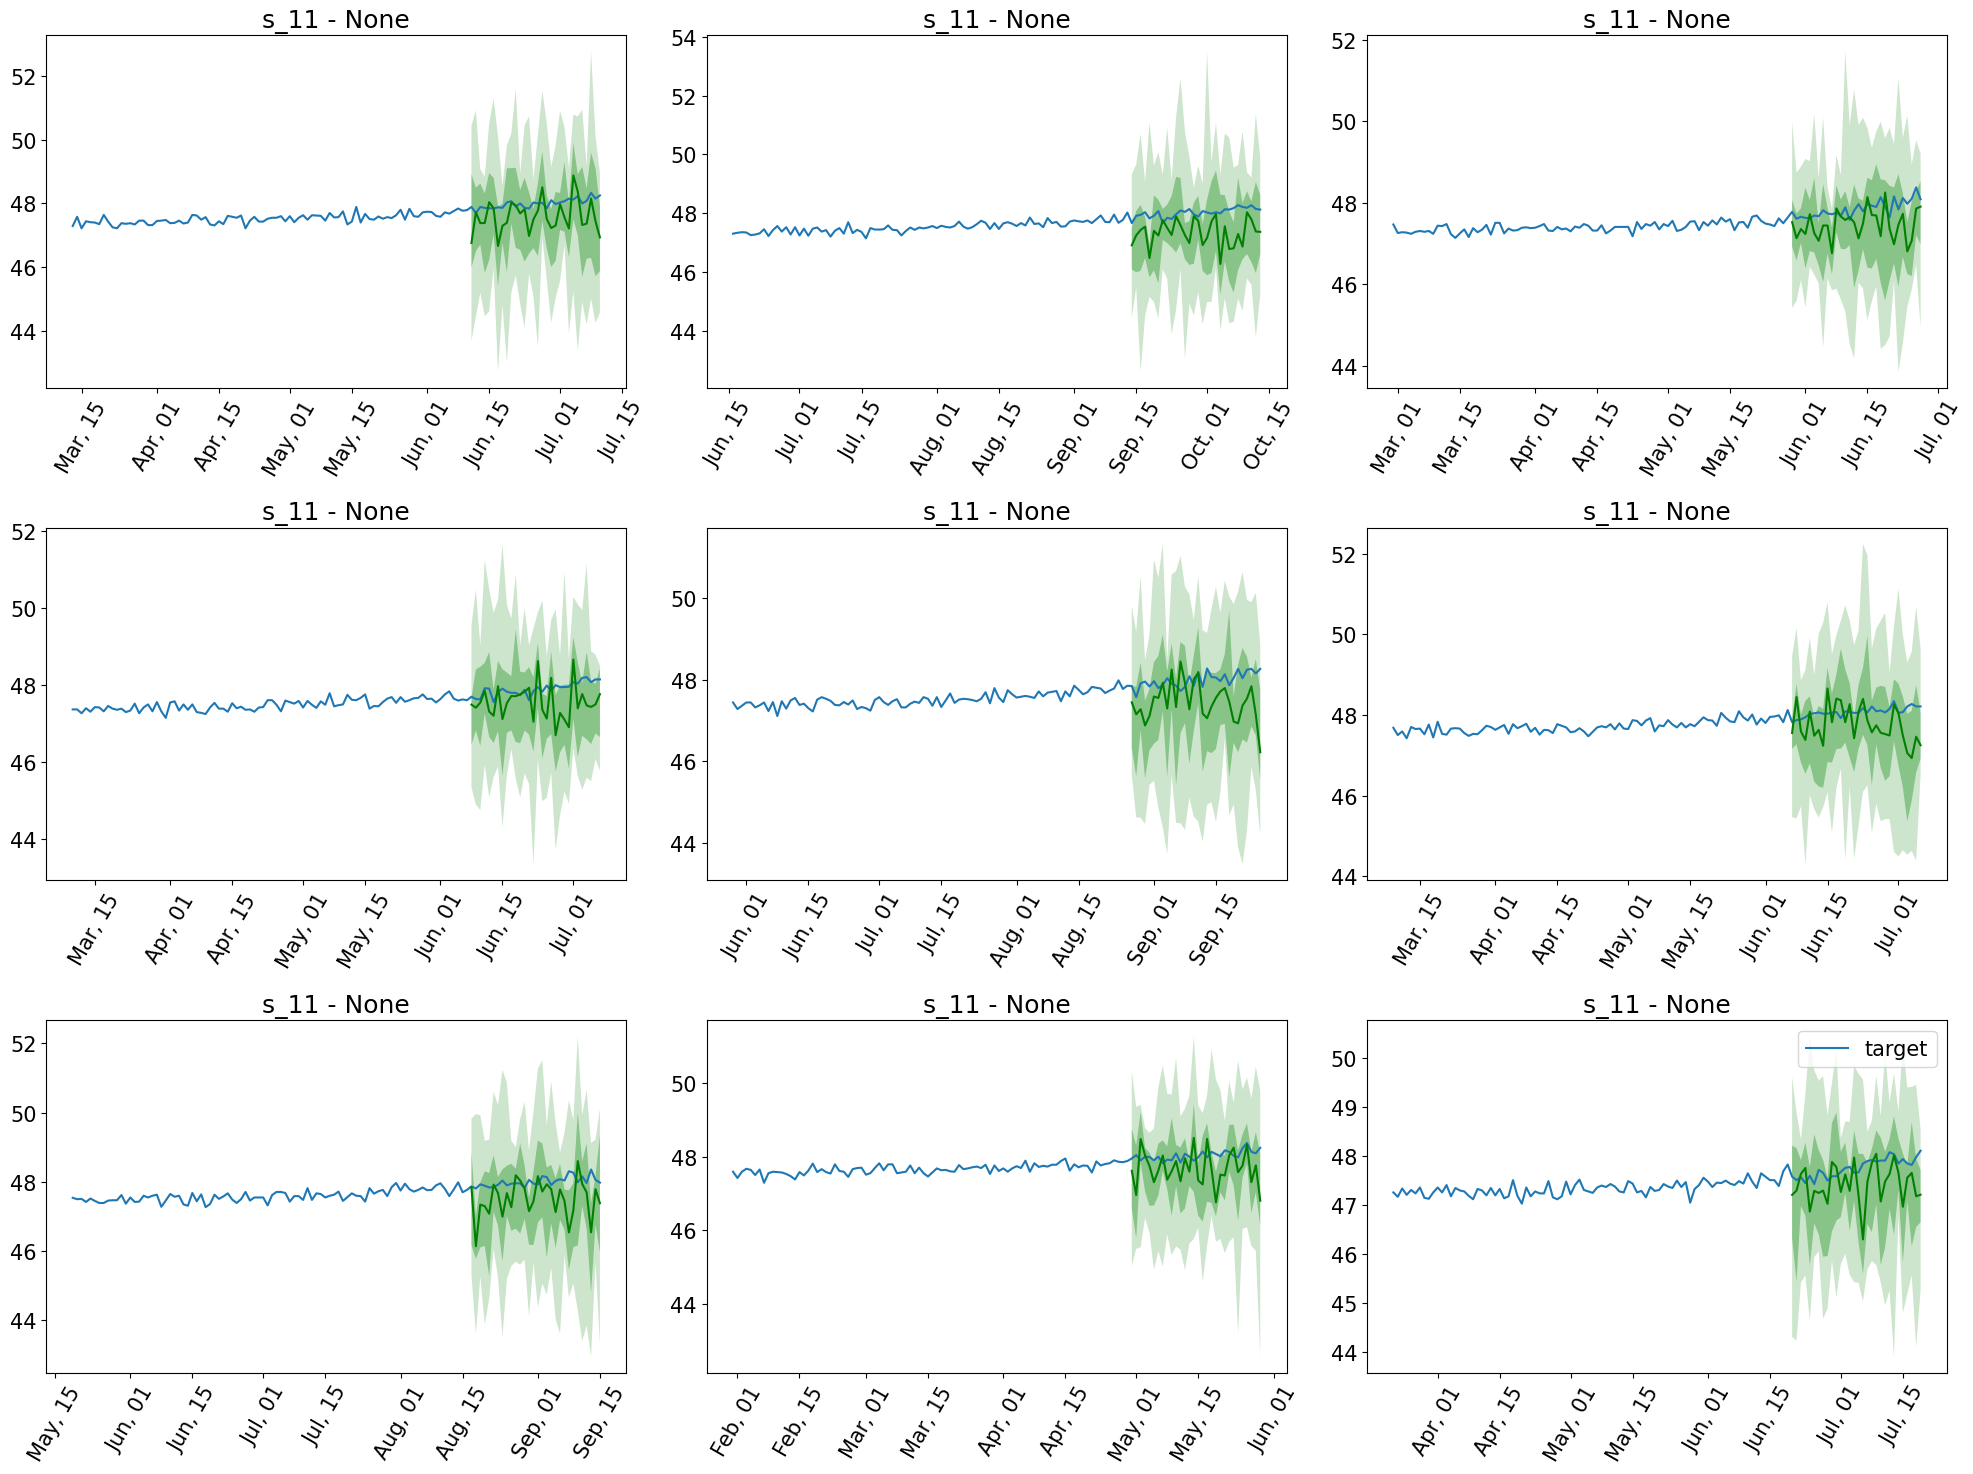

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_12, series 1: [522.4269  520.2674  522.4581  522.2706  522.0683  521.73926 521.91614
 519.1222  521.6498  522.4816  521.50085 521.02954 521.13666 521.71906
 522.6967  520.4208  523.3263  520.4942  522.48016 521.8532  519.0316
 521.25085 522.4889  522.07007 521.37854 521.659   521.4091  521.0846
 520.5073  521.7906 ]
Predictions for sensor s_12, series 2: [522.5686  521.1836  522.3695  521.4864  521.5828  521.42316 521.2334
 521.5924  524.069   522.139   523.4931  523.18085 521.2534  522.46063
 521.20703 523.3356  523.8892  522.9647  523.7535  523.599   521.3594
 521.9879  521.44727 521.5994  522.58887 522.3849  523.42316 521.9863
 522.10754 522.1733 ]
Predictions for sensor s_12, series 3: [522.8673  519.84125 523.0091  522.9643  522.0479  521.0366  523.10535
 521.67365 522.26715 521.5165  522.248   522.8116  520.5924  522.3031
 521.4098  520.6407  521.83844 520.6558  522.86633 521.0876  522.21246
 522.45905 522.51666 520.4904  523.5403  521.68933 521.5762  523

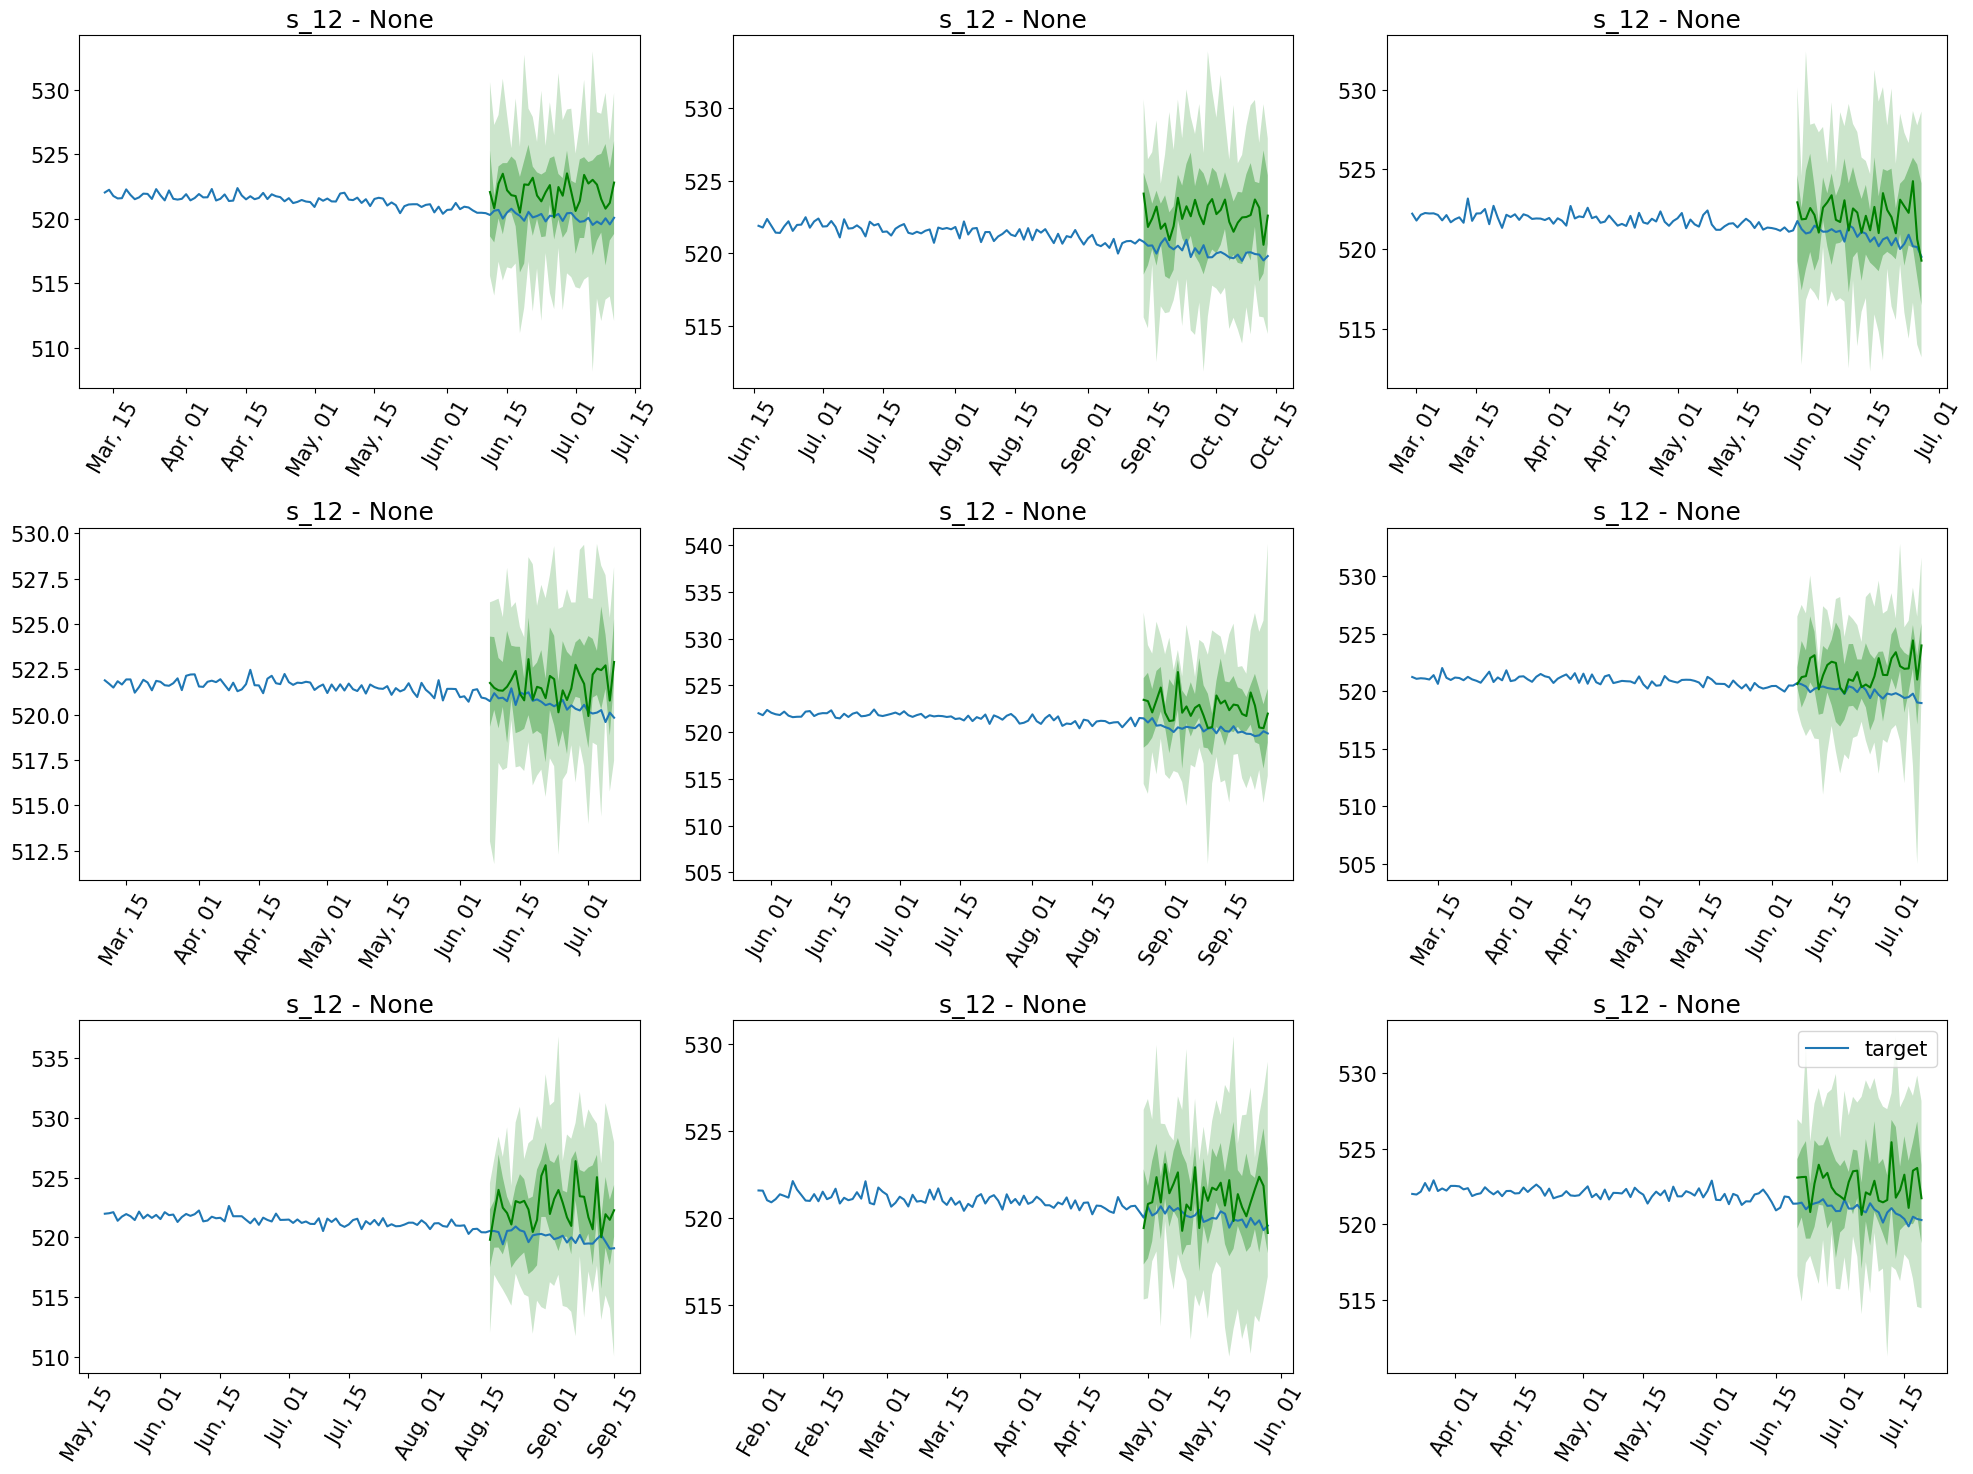

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_13, series 1: [2388.0337 2388.2485 2387.9023 2388.1277 2388.1877 2388.0645 2388.2427
 2387.9373 2388.1523 2388.075  2388.1055 2387.8877 2388.0867 2388.2476
 2388.104  2388.2114 2388.124  2388.2014 2388.1125 2387.939  2387.887
 2388.152  2388.0188 2388.029  2388.0076 2388.2168 2388.1208 2388.1958
 2388.139  2388.4365]
Predictions for sensor s_13, series 2: [2388.0933 2388.0676 2388.1992 2388.1353 2387.8096 2387.9106 2387.8833
 2388.231  2388.0645 2388.1663 2387.9805 2388.07   2387.9458 2388.0486
 2387.8992 2387.94   2388.0415 2388.0454 2388.212  2388.26   2388.2905
 2388.0044 2388.1167 2388.1157 2388.1167 2388.19   2387.9775 2387.9966
 2388.0706 2387.9329]
Predictions for sensor s_13, series 3: [2388.0515 2388.0496 2388.061  2388.0315 2388.0308 2388.083  2388.0532
 2388.0293 2387.9763 2388.029  2387.9314 2387.9395 2388.06   2388.077
 2388.023  2387.9631 2388.07   2388.036  2388.09   2388.081  2387.9353
 2388.0383 2388.0332 2387.978  2388.0042 2387.9827 2388.0876

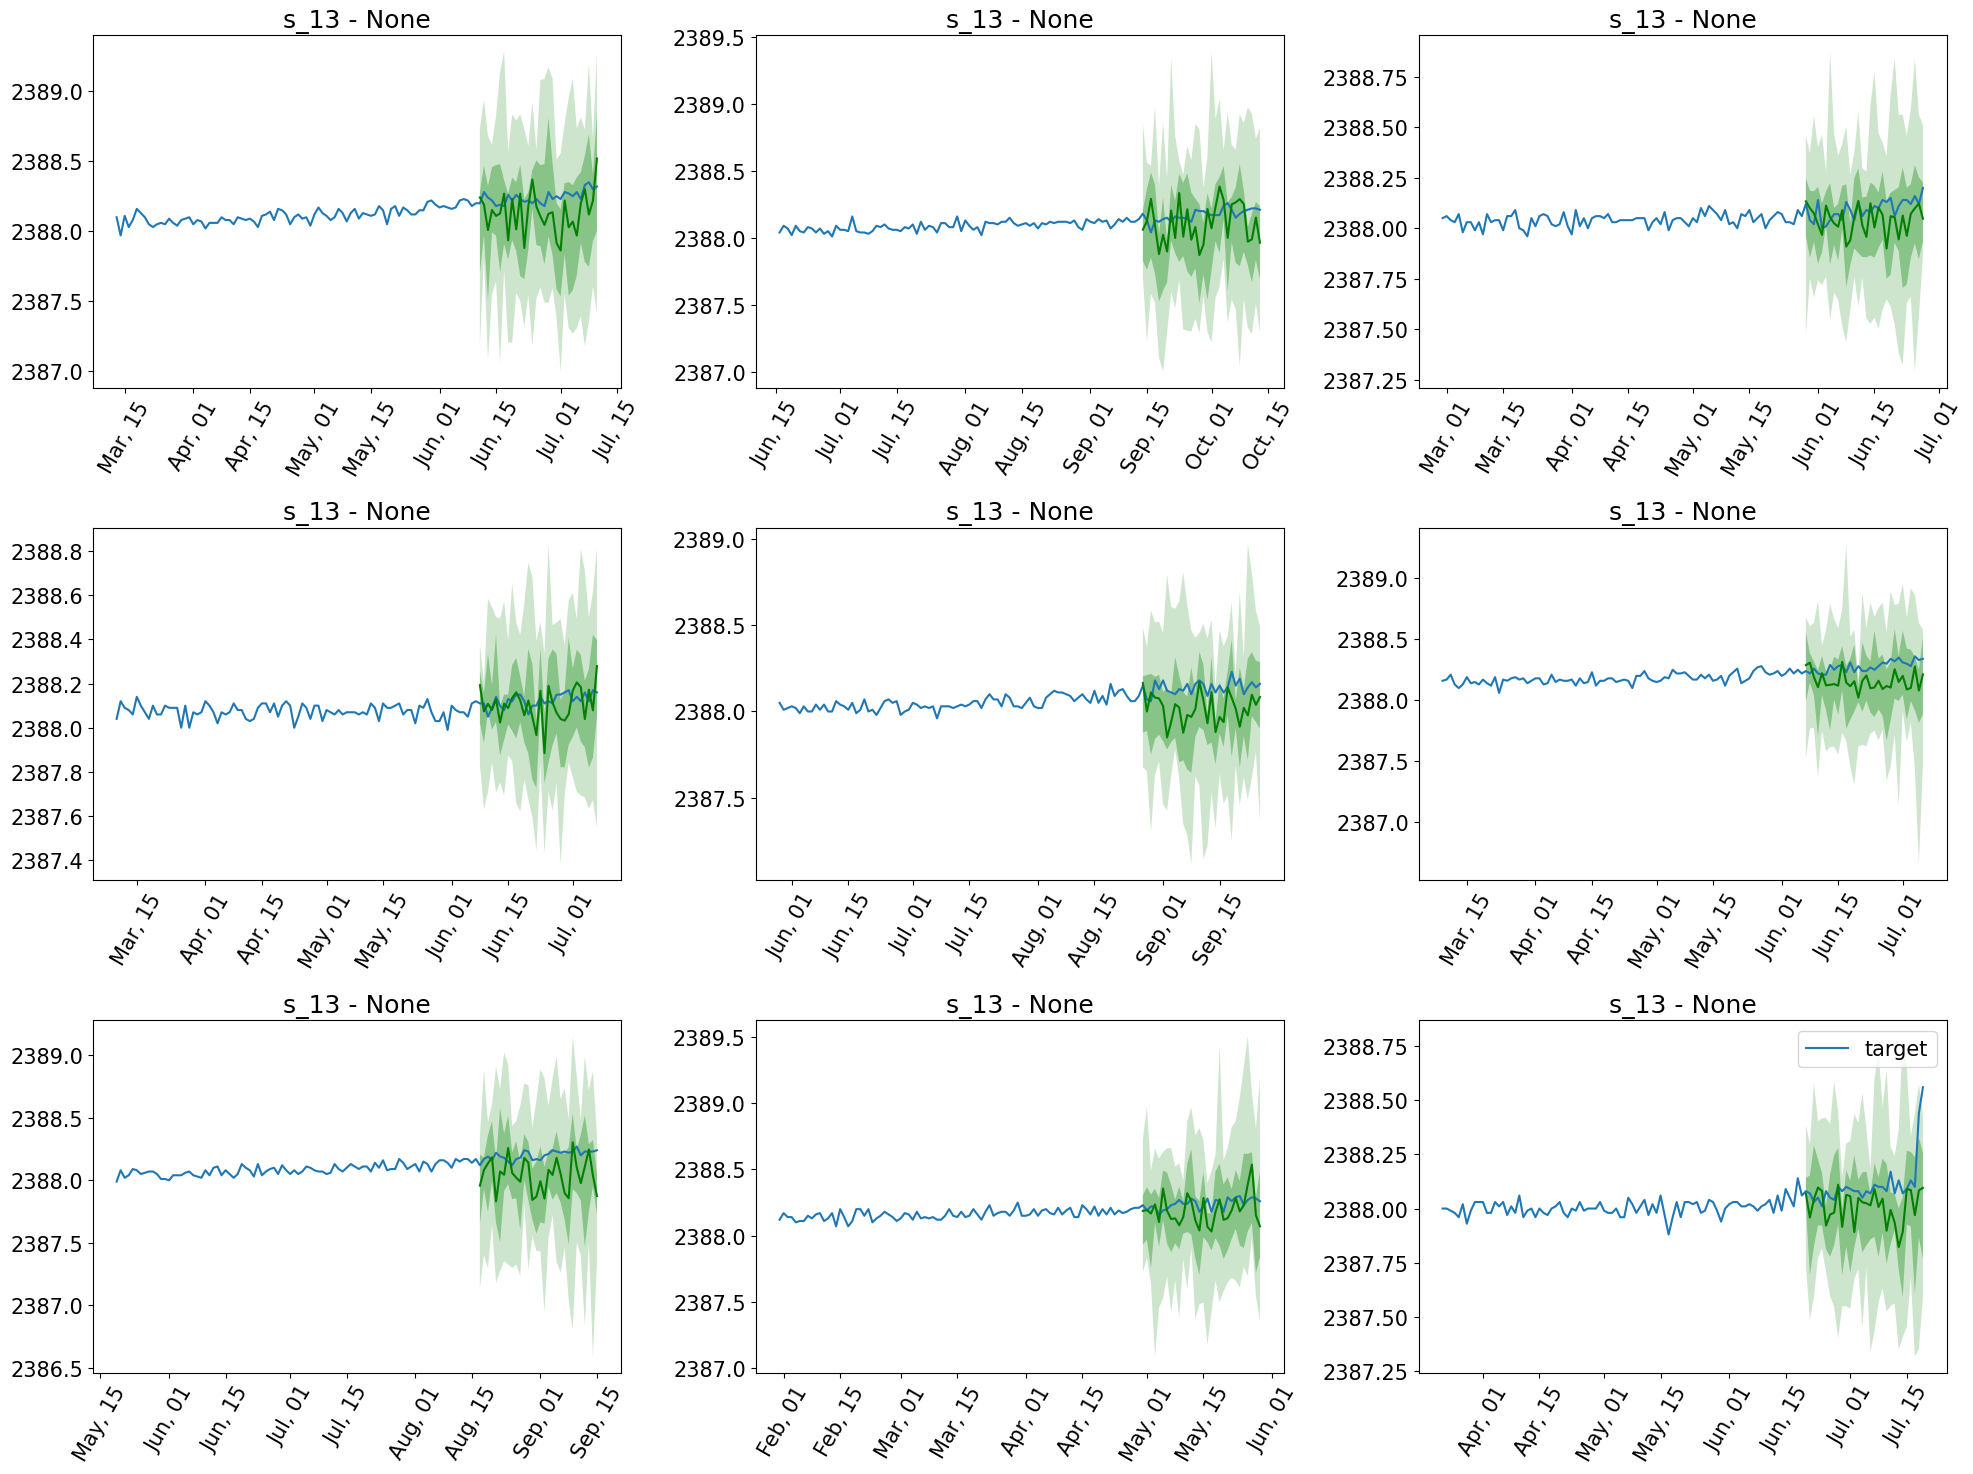

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_14, series 1: [8149.1914 8143.206  8140.971  8145.9287 8131.2734 8139.1704 8117.1694
 8131.2617 8119.7905 8133.233  8135.824  8126.3867 8133.6133 8126.7837
 8127.122  8130.711  8123.6343 8129.9546 8147.3447 8124.839  8144.3545
 8104.6084 8147.0767 8135.8115 8135.2827 8137.0264 8142.779  8115.0703
 8134.328  8145.9897]
Predictions for sensor s_14, series 2: [8119.6016 8123.253  8130.729  8131.1484 8140.5913 8154.3726 8149.6045
 8161.6045 8129.4053 8111.2656 8149.284  8156.3213 8138.3037 8149.0586
 8152.646  8138.432  8145.132  8148.178  8117.1064 8120.086  8163.7783
 8143.3516 8130.311  8141.1016 8142.5273 8147.626  8148.017  8122.8154
 8142.928  8122.8657]
Predictions for sensor s_14, series 3: [8174.585  8162.9546 8171.1743 8135.2314 8170.556  8125.346  8102.5664
 8147.372  8162.5225 8138.428  8147.6367 8129.9077 8110.9795 8170.5405
 8139.7695 8099.9116 8144.3413 8131.861  8154.3975 8172.757  8100.962
 8106.8125 8155.329  8146.932  8112.8022 8136.5    8155.947

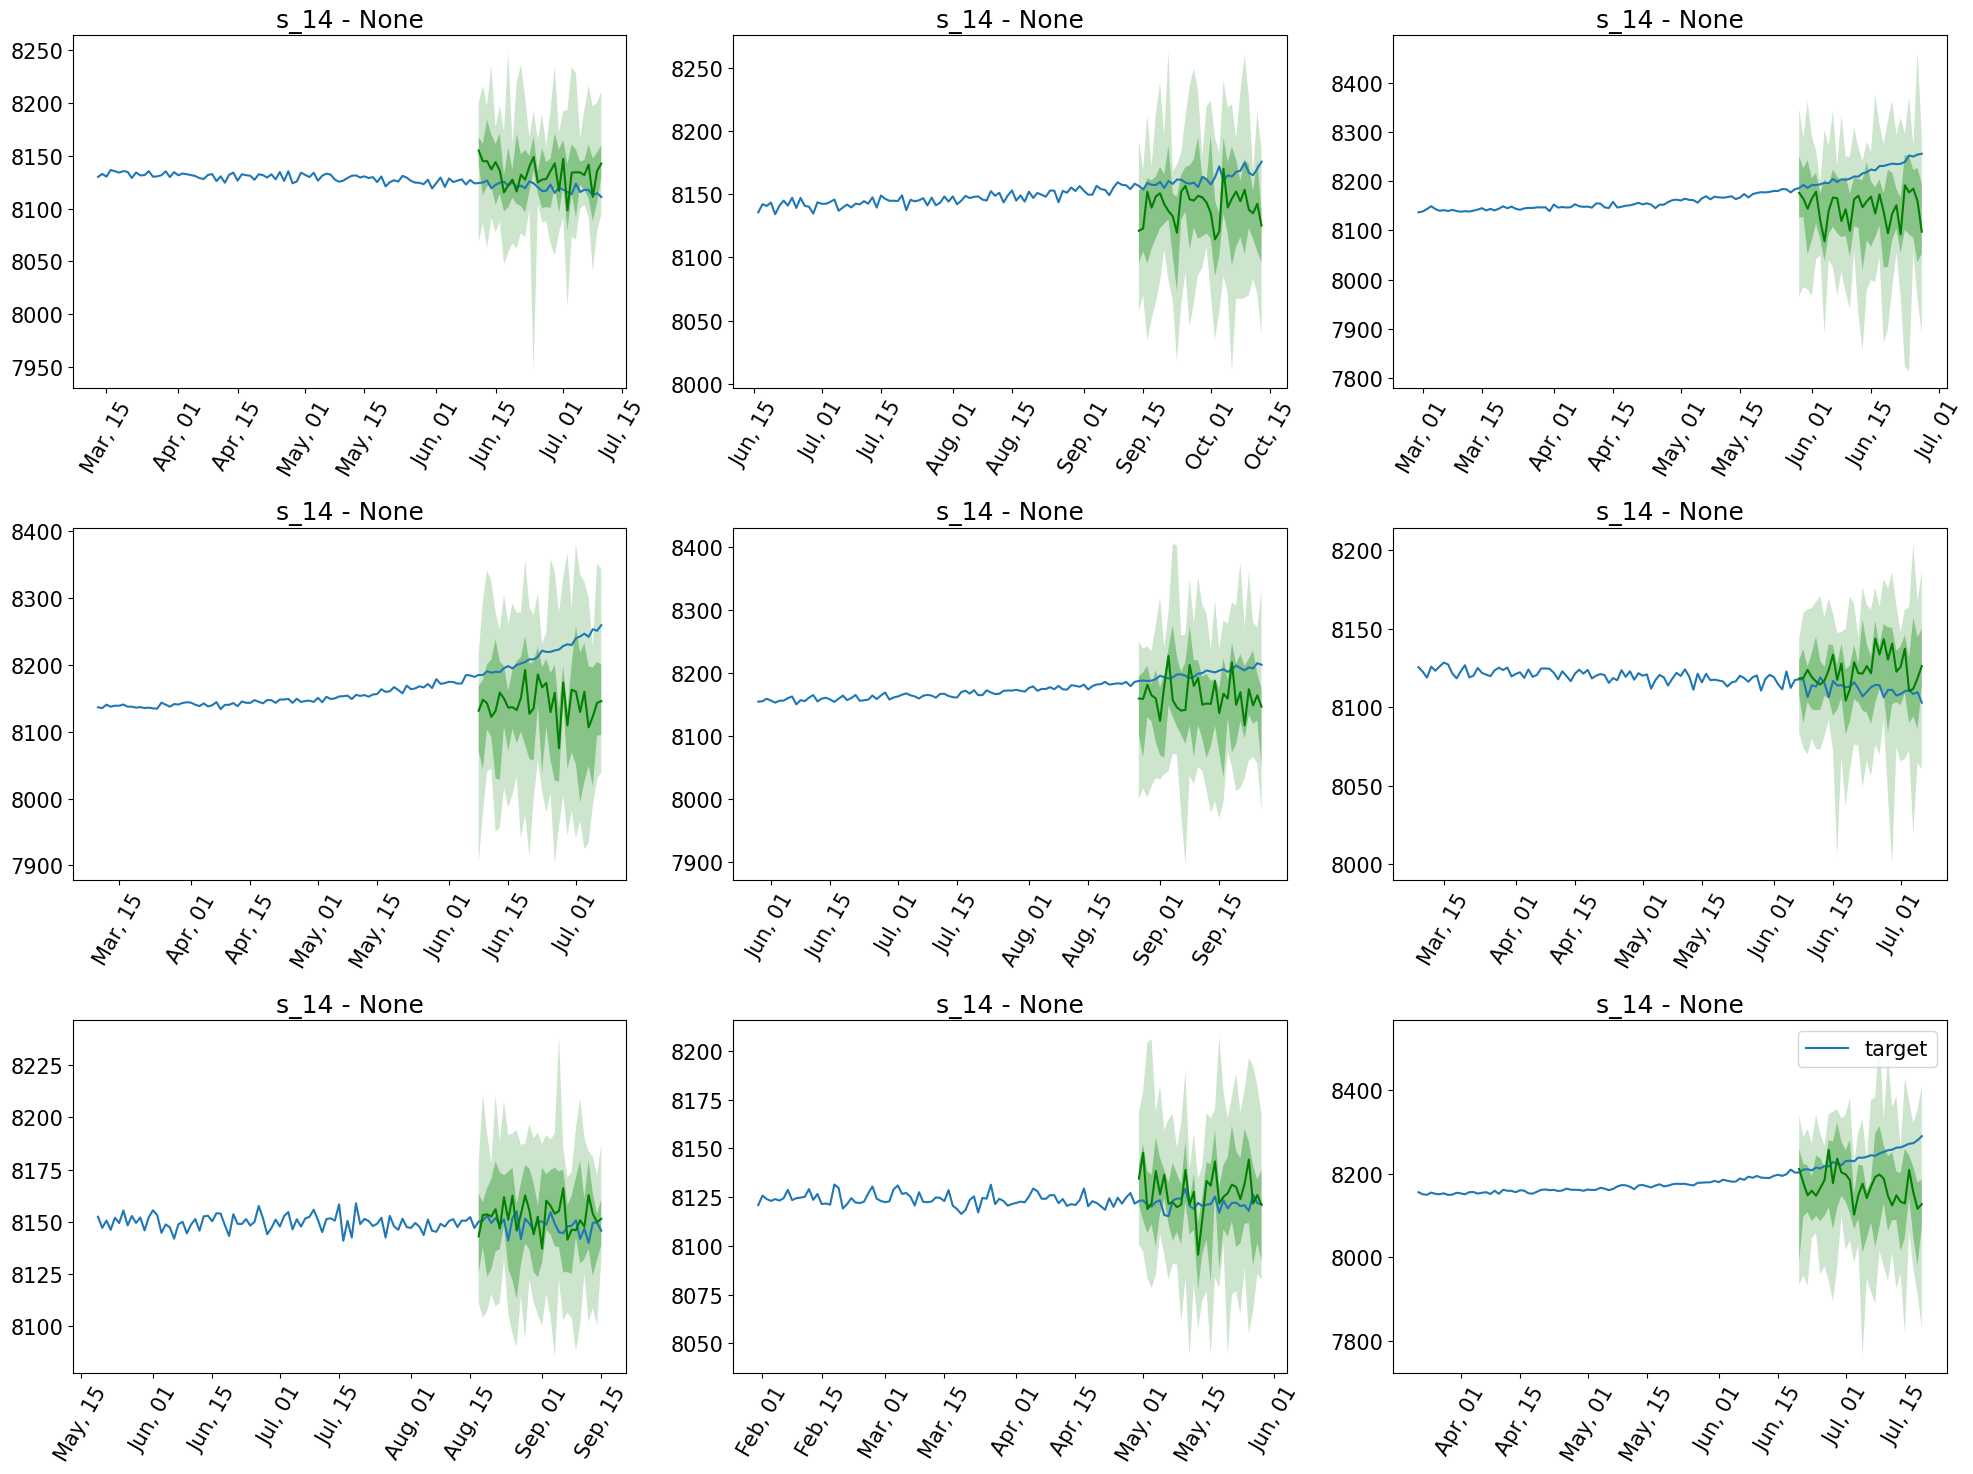

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_15, series 1: [8.481259  8.474279  8.471012  8.322668  8.444711  8.437605  8.445193
 8.426157  8.365238  8.452502  8.455478  8.375847  8.496665  8.5015545
 8.476249  8.385778  8.3762455 8.479953  8.424028  8.358073  8.421656
 8.420042  8.380603  8.324428  8.355368  8.3794    8.391236  8.4335785
 8.458462  8.438984 ]
Predictions for sensor s_15, series 2: [8.395855  8.3995285 8.434382  8.430681  8.405256  8.396167  8.402581
 8.431292  8.466939  8.444911  8.383107  8.407242  8.38212   8.377079
 8.47886   8.448416  8.454726  8.481084  8.292868  8.461103  8.369749
 8.398176  8.537019  8.403197  8.493342  8.425087  8.3925495 8.42308
 8.417807  8.485327 ]
Predictions for sensor s_15, series 3: [8.3853245 8.413214  8.489212  8.49743   8.47539   8.471541  8.472386
 8.440847  8.486635  8.415045  8.469629  8.364378  8.3910475 8.365503
 8.354813  8.559527  8.502134  8.319705  8.377955  8.39761   8.496625
 8.495945  8.342139  8.372731  8.446307  8.506666  8.310399  8.36260

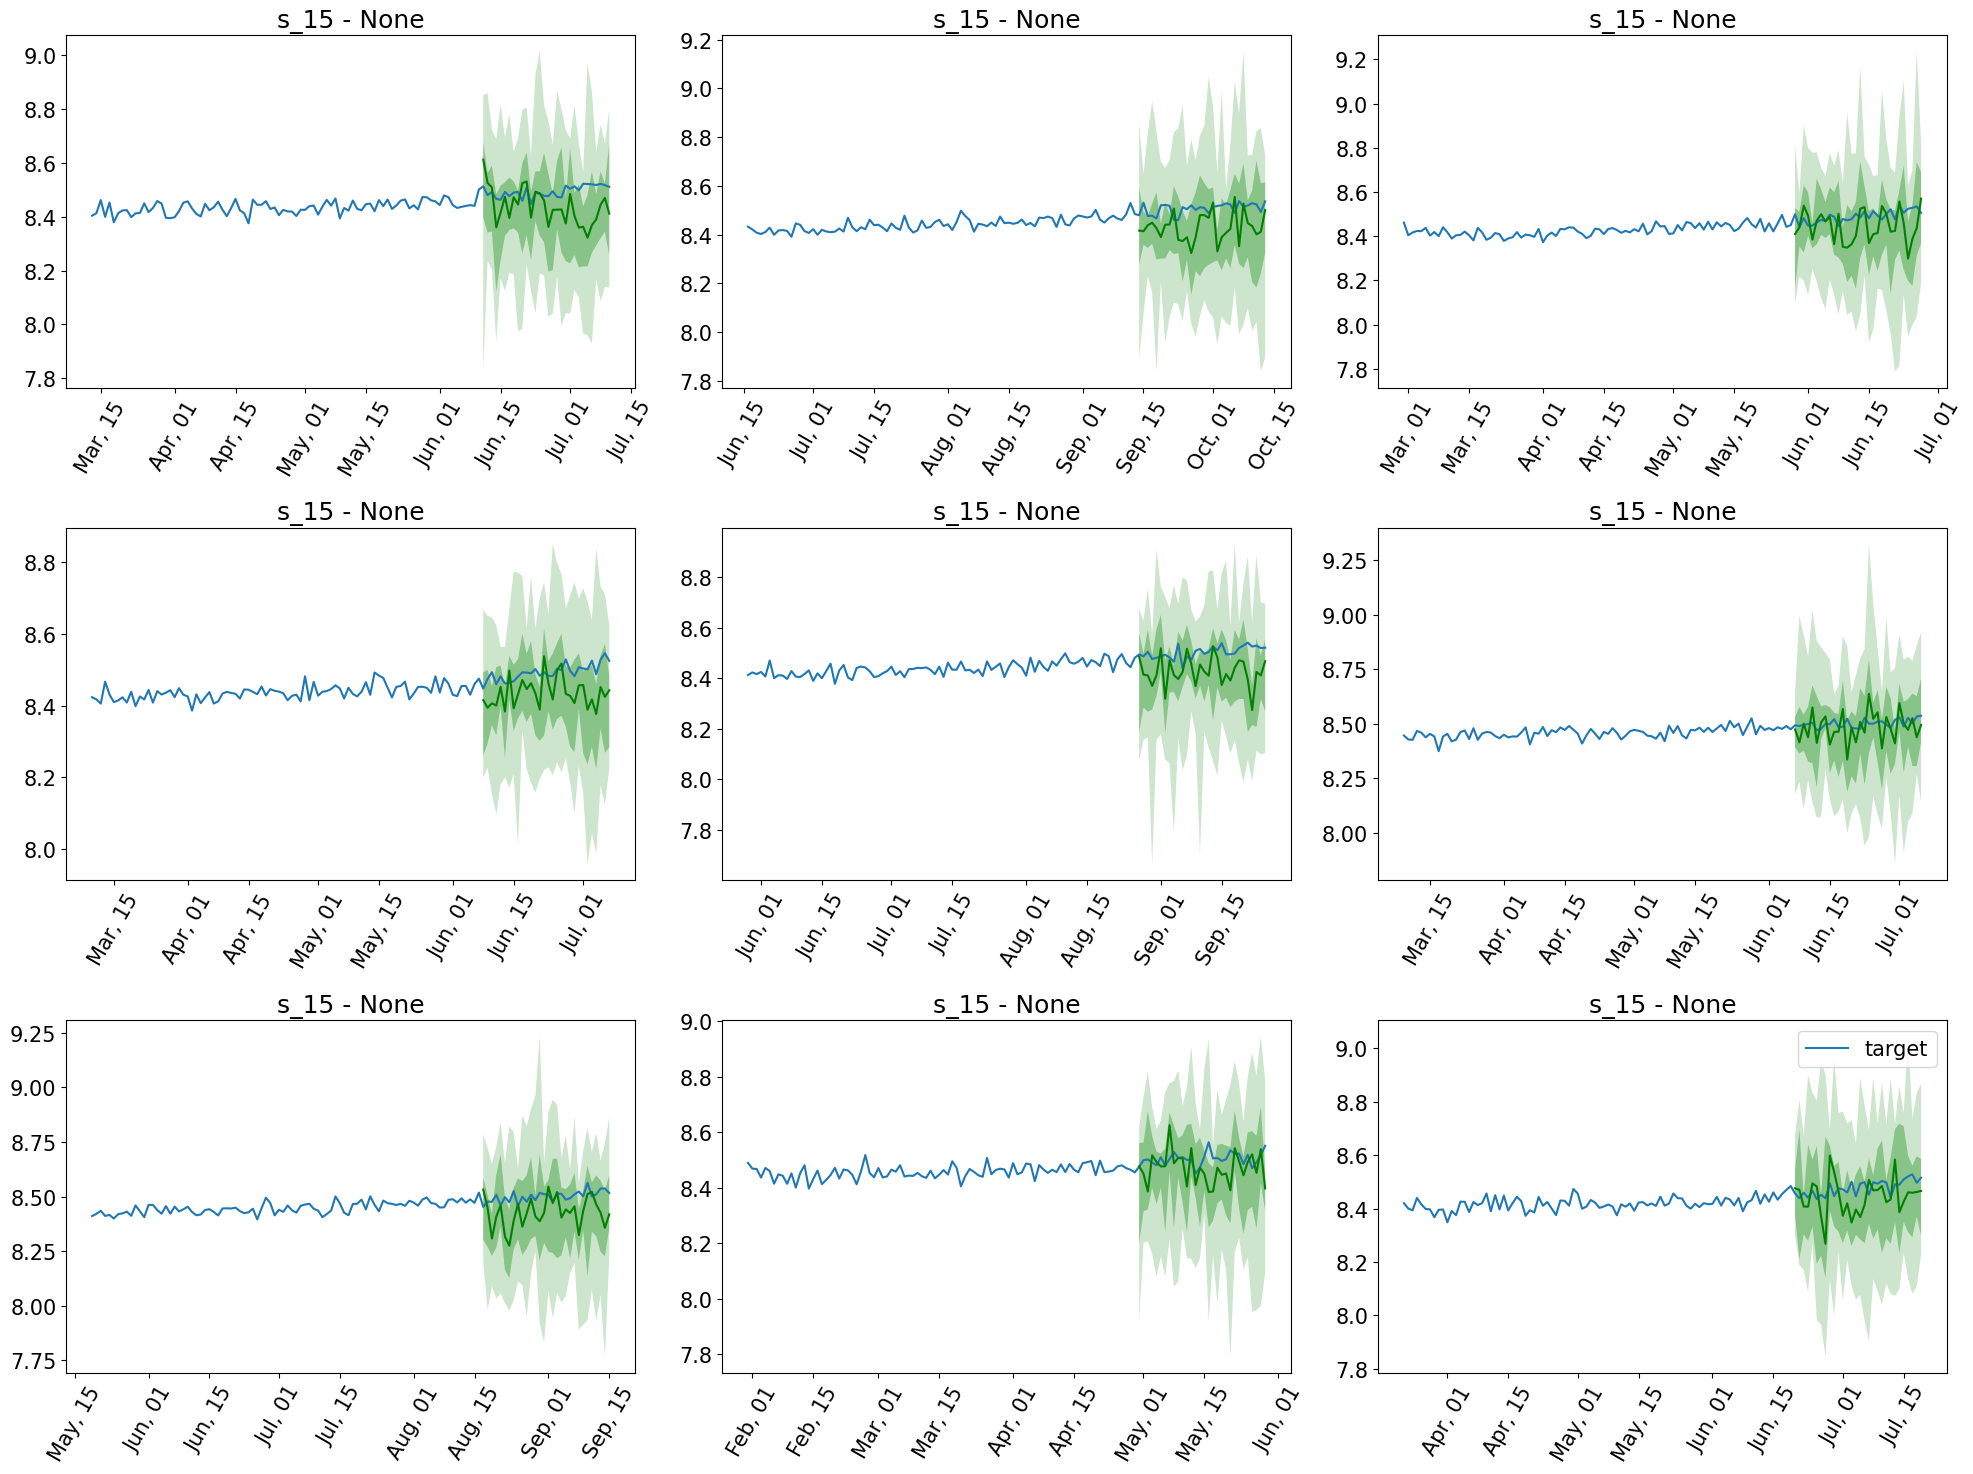

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_17, series 1: [392.16577 393.424   391.57608 392.0377  392.10184 391.3195  390.95453
 393.0584  392.3591  390.76398 392.9334  394.40607 392.33224 391.94644
 389.498   392.49304 391.68872 392.71304 393.6978  393.7595  391.35266
 390.59488 391.75885 390.99756 392.25214 393.39966 392.37262 390.15277
 392.5871  390.68384]
Predictions for sensor s_17, series 2: [396.74988 393.54617 388.63345 394.1589  392.00348 392.86813 394.74716
 394.42365 392.89142 387.0384  391.6978  392.1124  387.82596 395.32336
 396.1426  392.96402 394.19635 390.0733  390.64667 390.65253 392.02347
 395.30386 388.79083 395.3081  390.99457 385.42773 391.90158 391.99075
 391.05463 392.56406]
Predictions for sensor s_17, series 3: [387.96133 392.68134 391.63232 390.67792 390.1116  391.43964 392.66425
 393.56488 389.21274 392.85648 389.6544  391.23224 391.20026 388.1713
 393.47525 390.48987 395.55014 391.94565 393.0663  390.91614 391.9626
 394.72473 393.33258 393.87613 398.11865 388.73813 389.69992

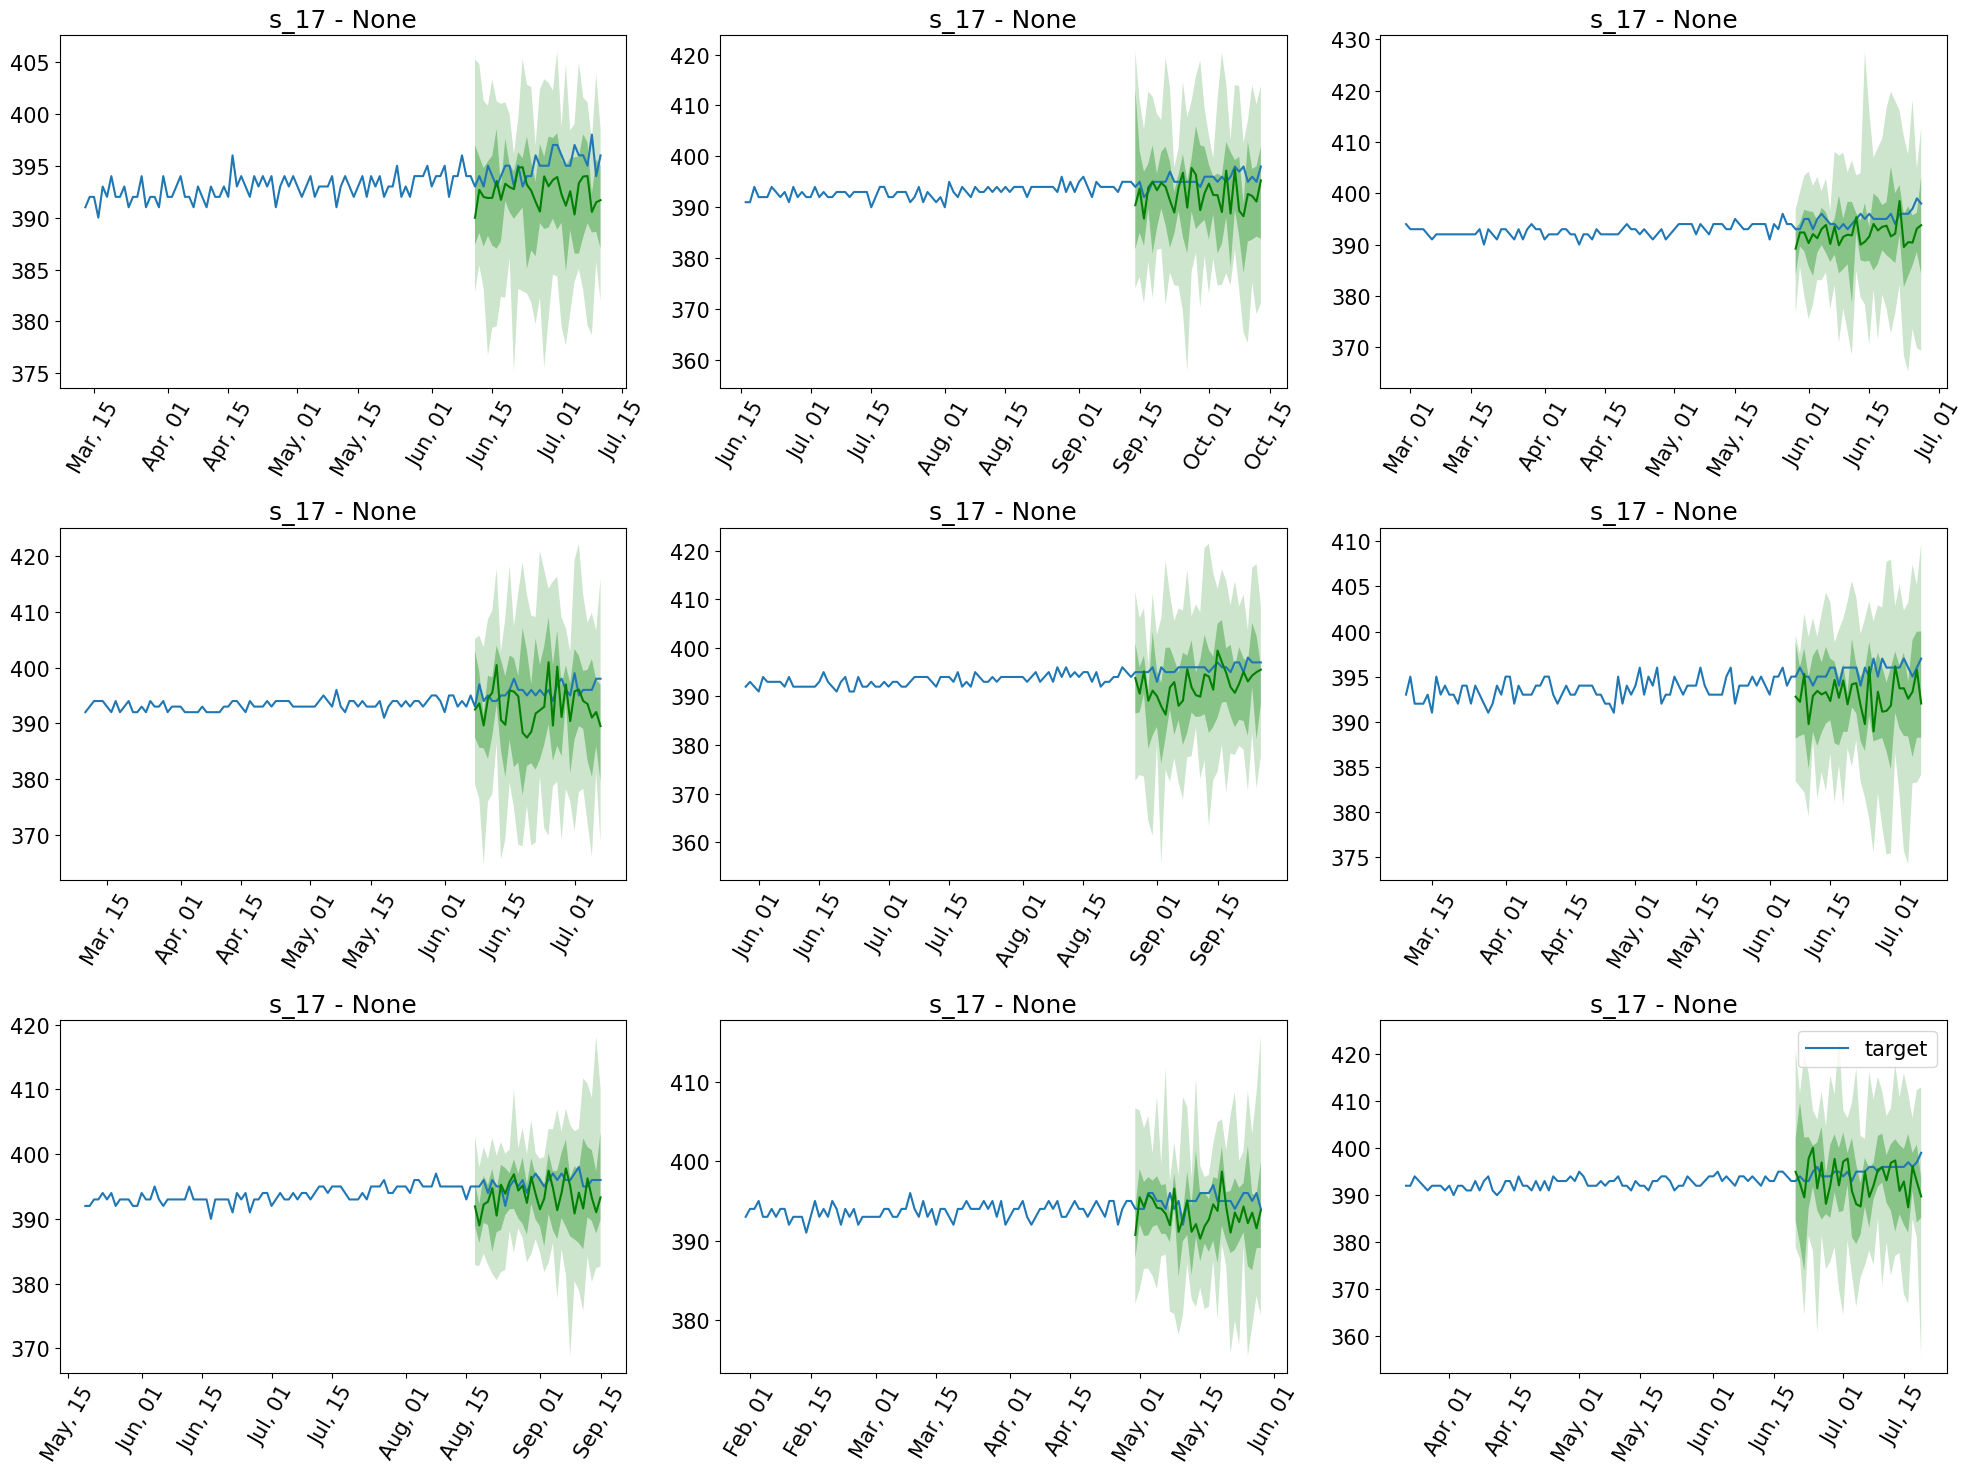

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_18, series 1: [2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388.]
Predictions for sensor s_18, series 2: [2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388.]
Predictions for sensor s_18, series 3: [2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388.]
Predictions for sensor s_18, series 4: [2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388.
 2388. 2388. 2388. 2388. 2388. 2388.]
Predictions for sensor s_18, series 5: [2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 2388. 23

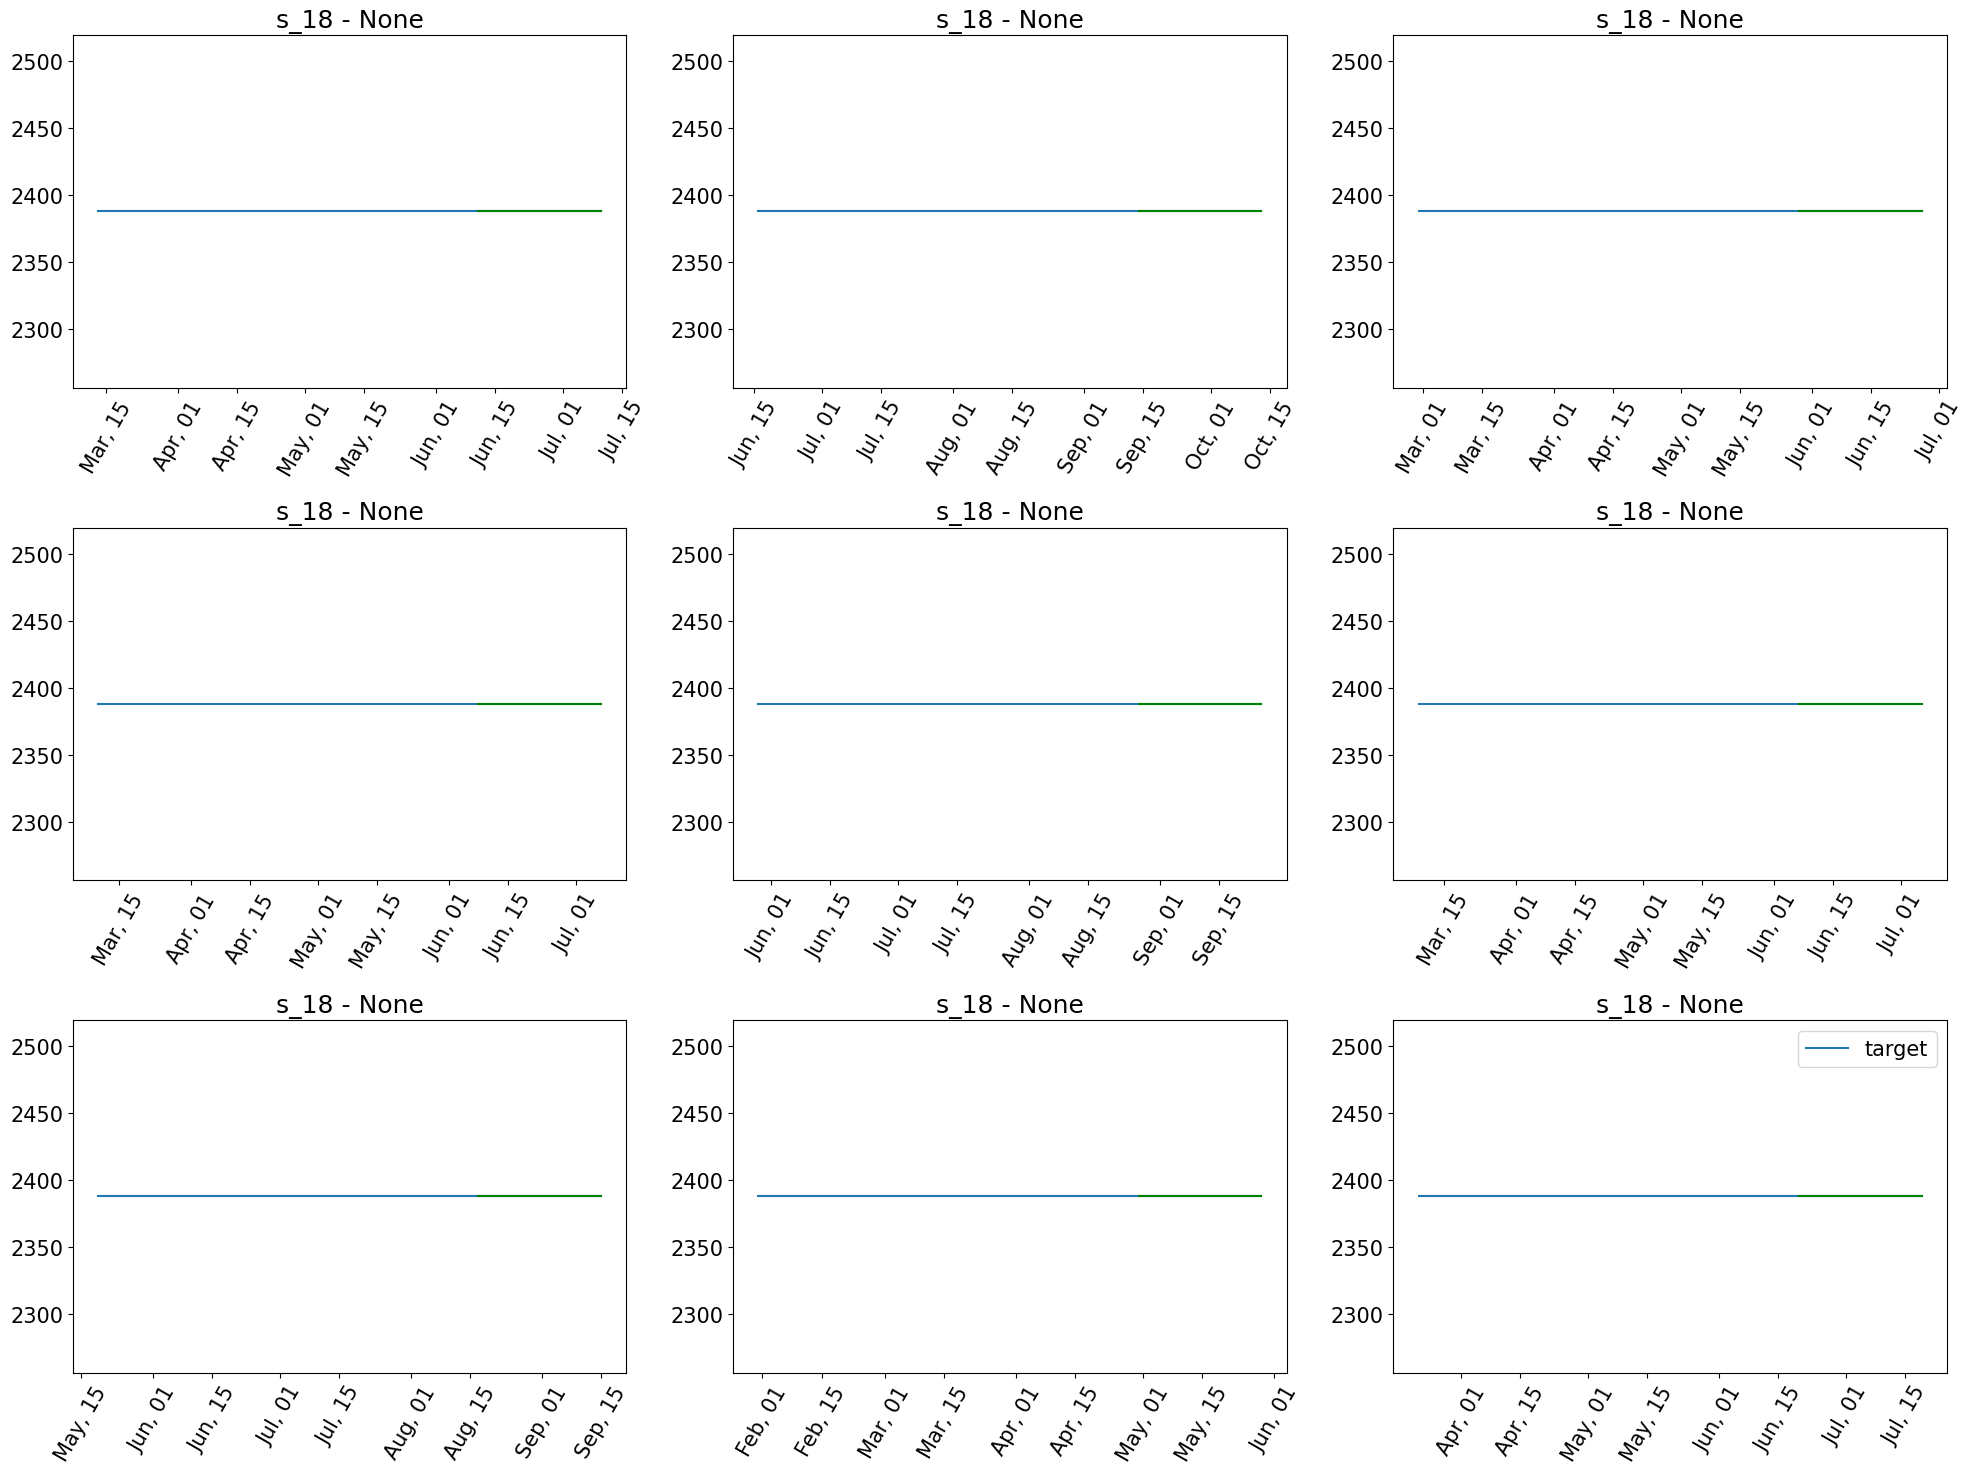

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_20, series 1: [38.58911  39.186768 39.02309  38.774384 38.927765 39.162495 39.19919
 38.70358  38.86894  38.513725 38.795662 38.766975 38.509254 38.30274
 38.622574 38.704773 38.985077 38.556328 38.85957  39.188076 38.79947
 39.14136  38.924145 39.456535 38.913685 38.699852 39.34583  38.596138
 39.167824 38.985855]
Predictions for sensor s_20, series 2: [39.11063  39.139038 38.482384 38.532013 39.023384 39.17176  39.11405
 38.691387 38.91721  39.008797 39.19179  39.226864 38.906044 39.097973
 38.761066 38.381016 39.010117 38.94643  38.91372  38.843727 38.493908
 39.07093  39.159916 39.621517 39.08894  39.480934 38.79533  38.899384
 39.48919  38.151104]
Predictions for sensor s_20, series 3: [38.965767 39.017574 38.8834   38.693684 38.995354 38.888386 38.884617
 39.01665  39.052376 39.3367   39.229515 38.849392 38.89402  38.87038
 39.04996  39.122902 39.34424  38.597576 39.23965  38.458076 39.160458
 38.94163  38.910286 38.868954 38.94283  39.13341  38.780132 38

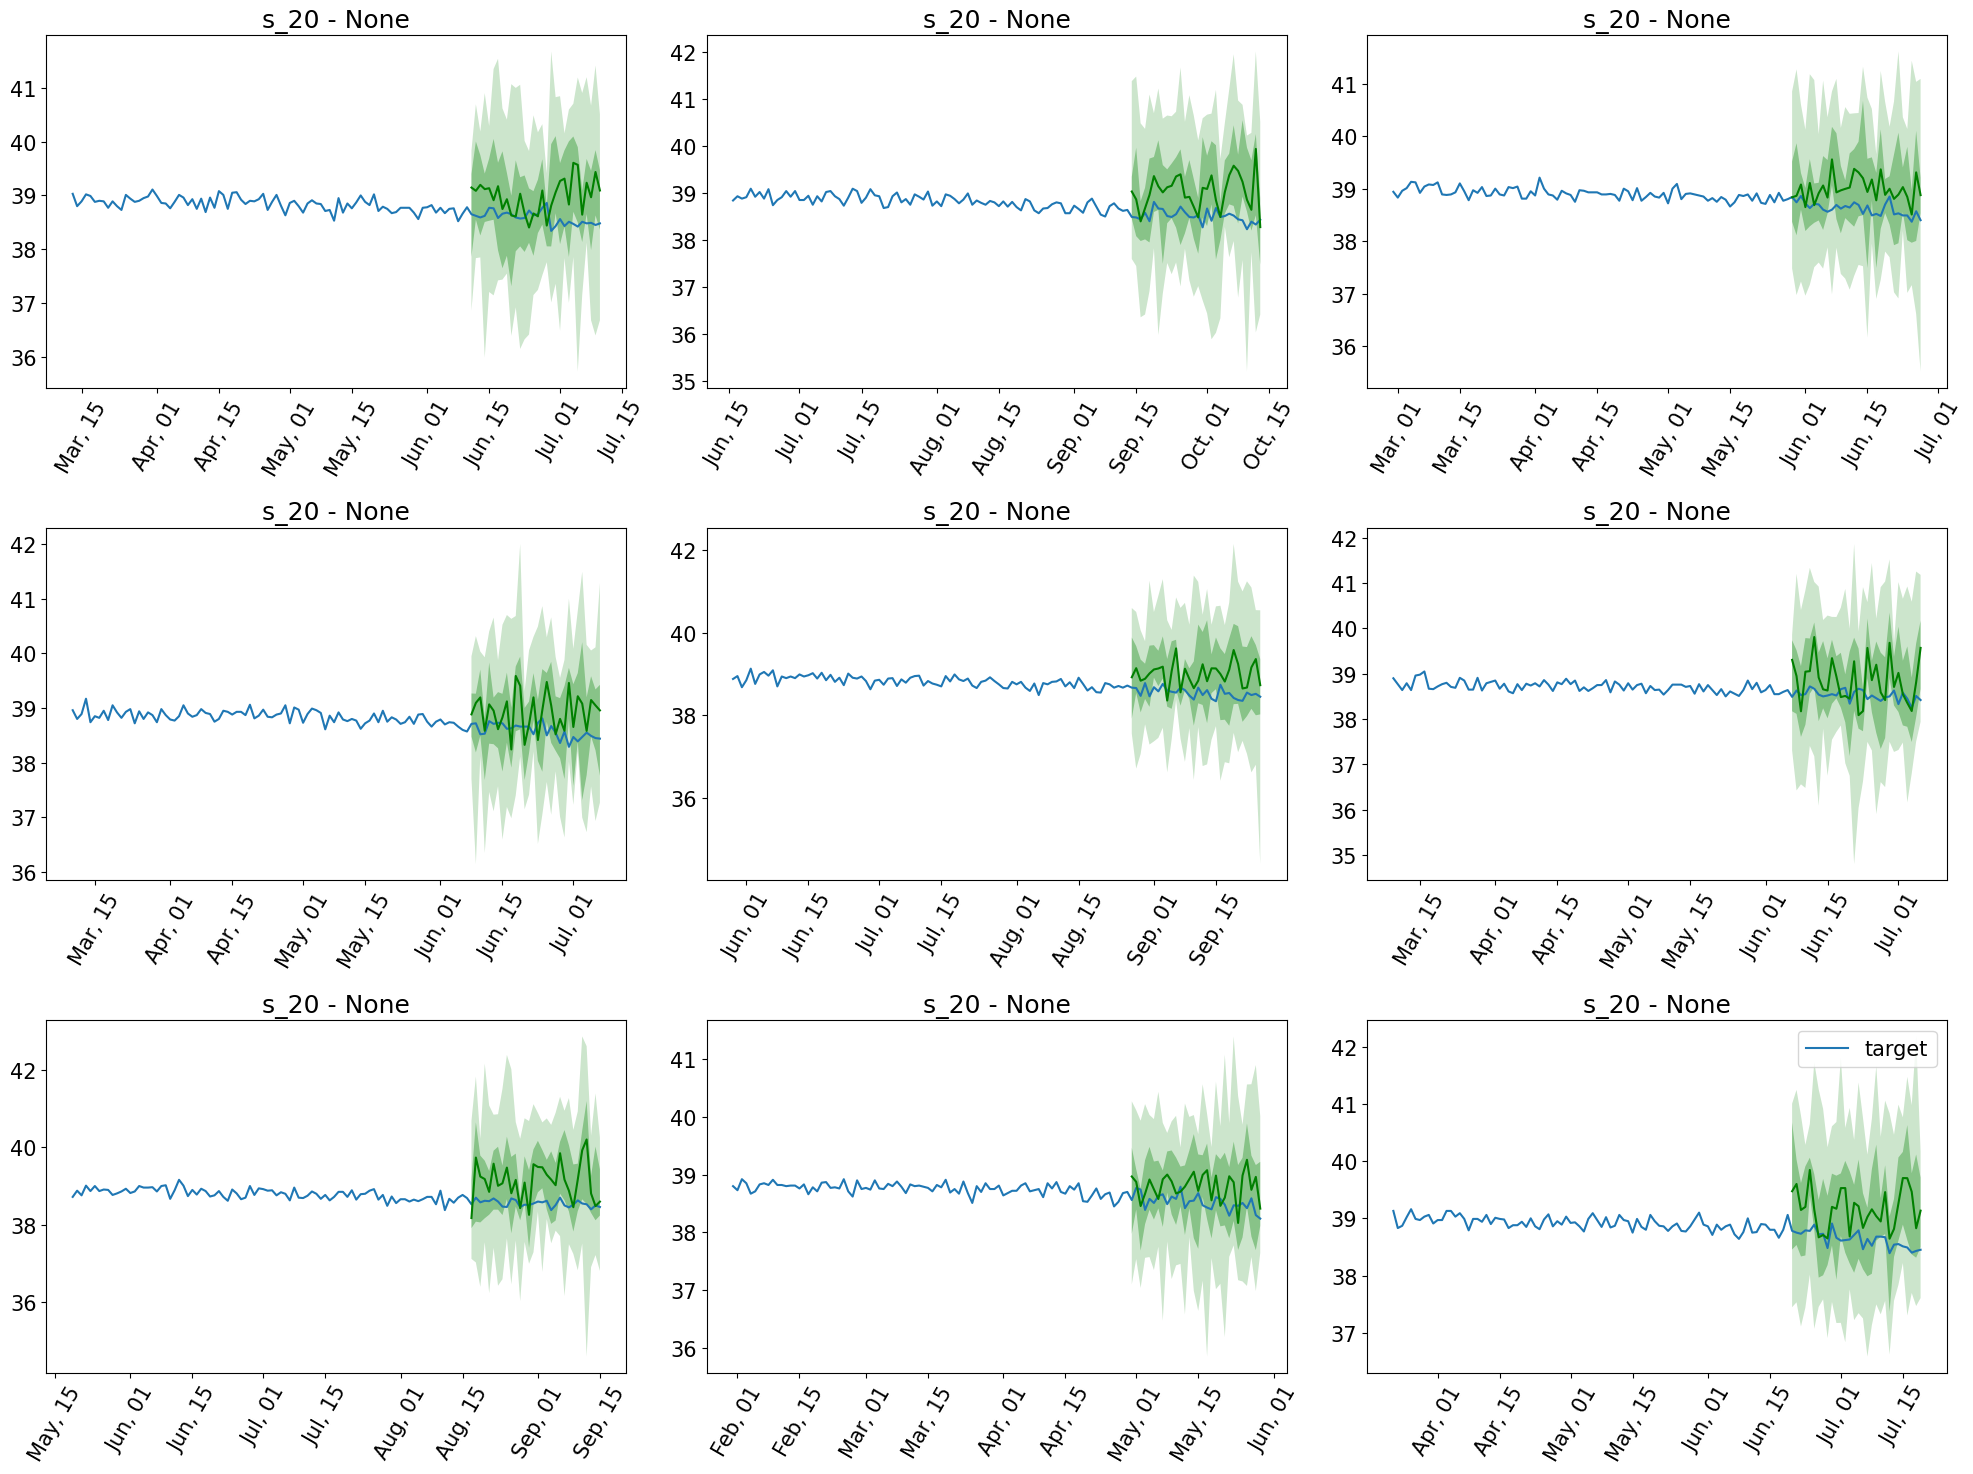

Forecasting batches:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Predictions for sensor s_21, series 1: [23.364006 23.234396 23.281534 23.527134 23.13727  23.176853 23.646166
 23.694107 23.37067  23.343264 23.372316 23.474981 23.478033 23.287039
 23.103888 23.325941 23.424406 23.359344 23.34159  23.247702 23.417768
 23.126984 23.524054 23.61894  23.341778 23.185871 23.049038 22.98315
 23.336325 23.140419]
Predictions for sensor s_21, series 2: [23.43449  23.458471 23.35768  23.12733  23.44926  23.145504 23.51085
 23.72936  23.380363 23.610634 23.404913 23.382927 23.291433 23.477146
 23.407154 23.277212 22.974268 23.655628 23.345446 23.215668 23.428453
 23.066826 23.234379 23.419147 23.106684 23.152382 23.375053 23.111736
 23.629965 23.536695]
Predictions for sensor s_21, series 3: [23.299736 23.227554 23.325586 23.370737 23.33619  23.654842 23.168636
 23.330517 23.591442 23.491573 23.045687 23.669016 23.212423 23.150906
 23.498196 23.394987 23.22027  23.541819 23.31011  23.623562 23.161844
 23.45504  23.655119 23.503231 23.221712 23.271187 23.460688

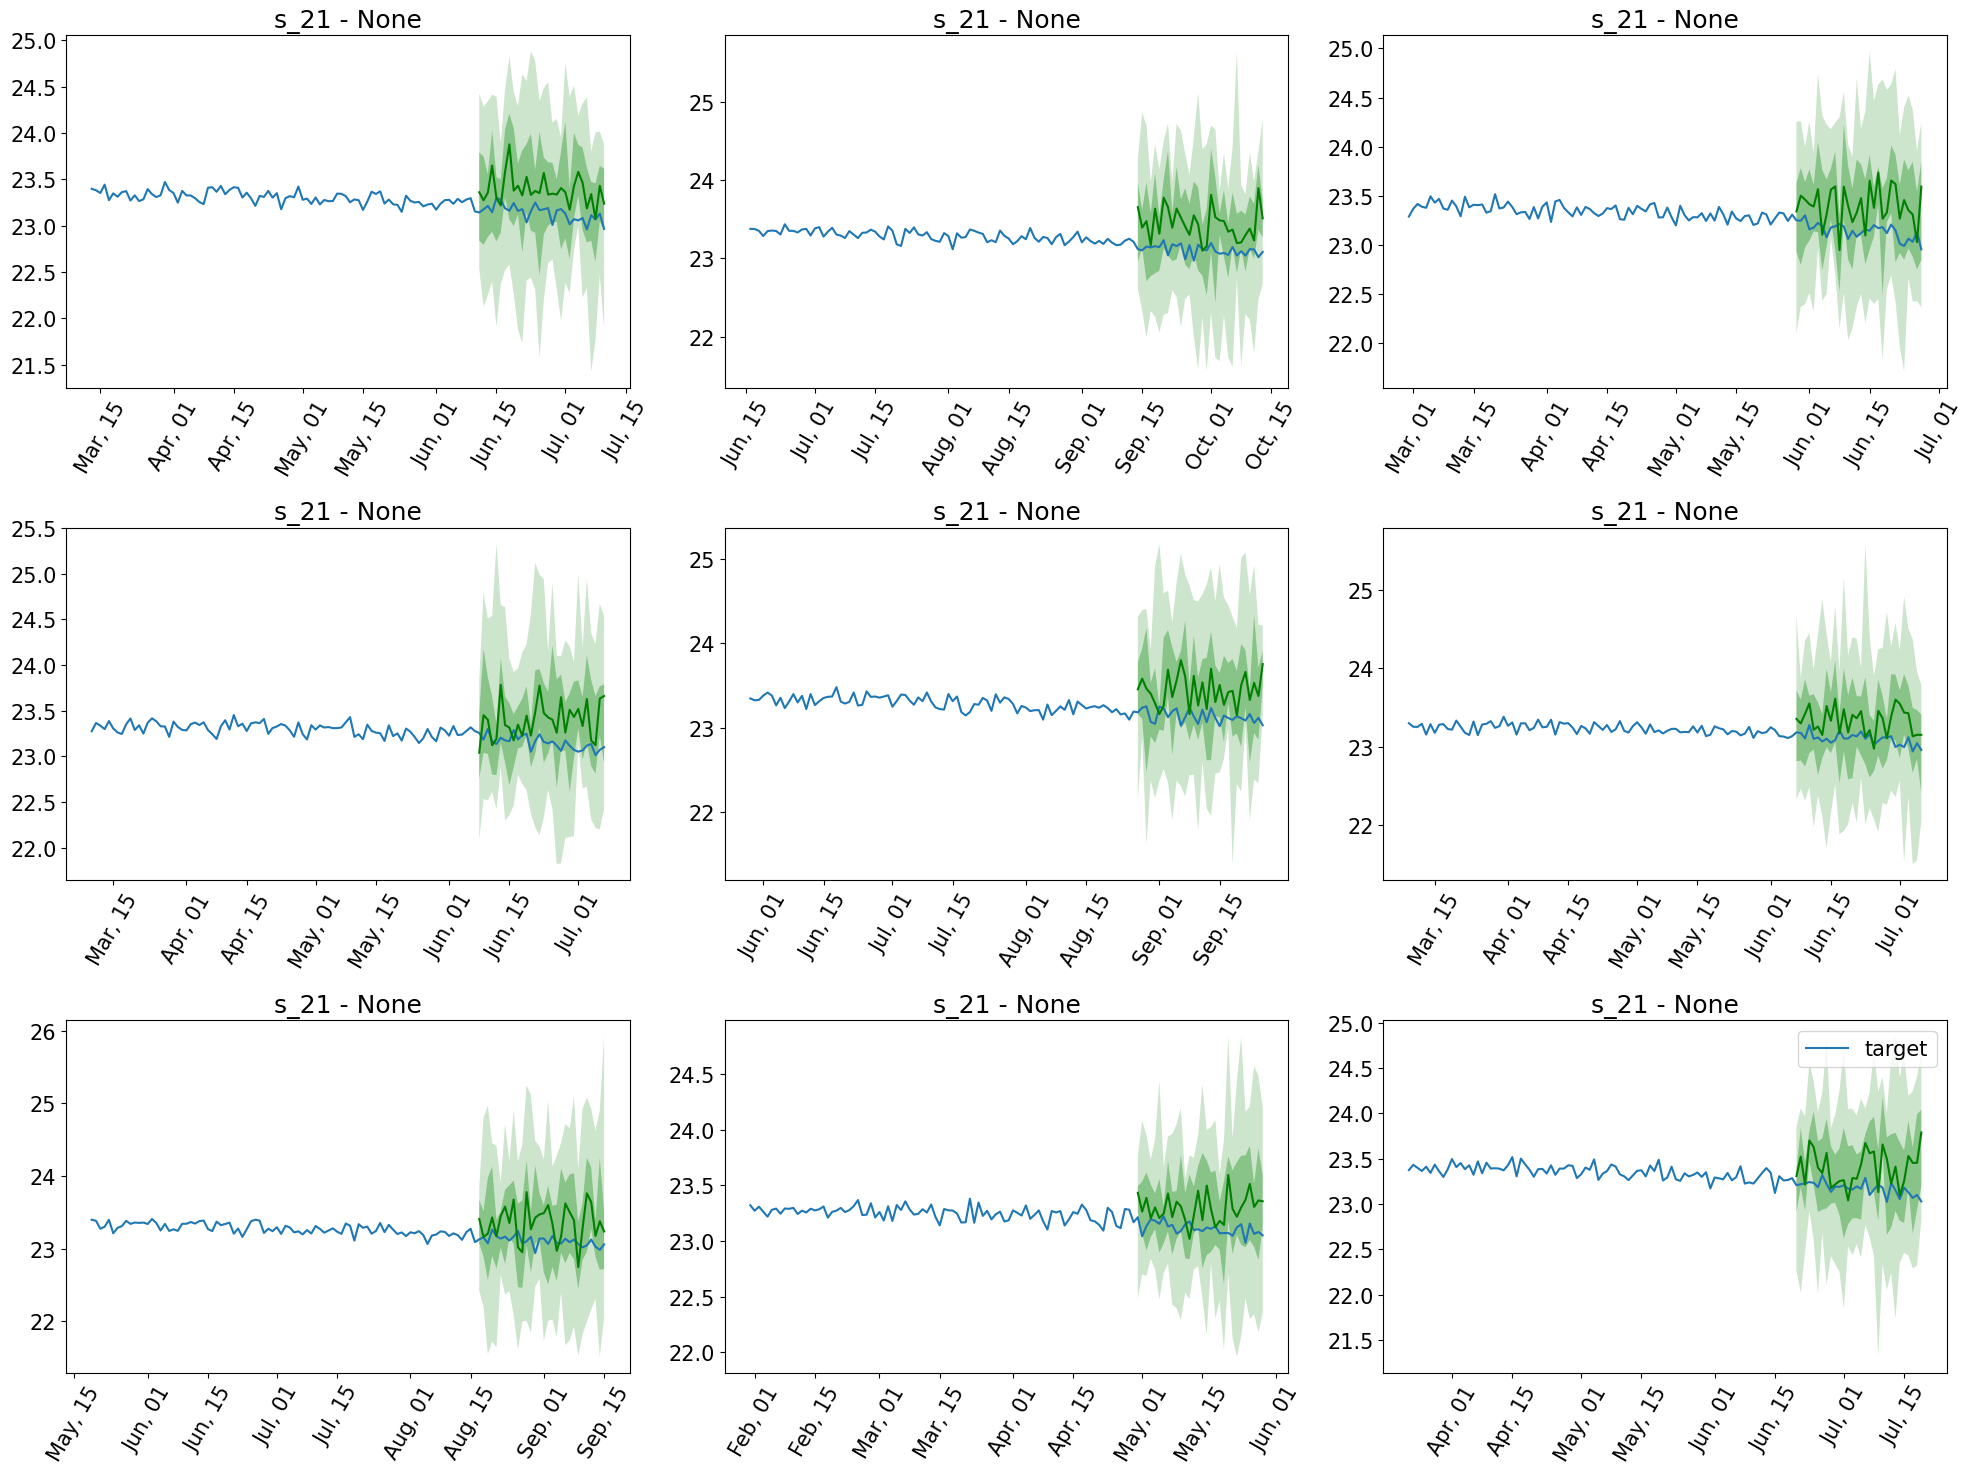

In [58]:
# Plot forecasts for each sensor
for sensor, sensor_dataset in datasets.items():
    # Generate forecasts and ground truth time series for the current sensor
    forecasts, tss = get_lag_llama_predictions(
        sensor_dataset,
        prediction_length=prediction_length,
        num_samples=num_samples,
        context_length=context_length,
        device=device
    )
     # Set up the plot figure with a specific size
    plt.figure(figsize=(20, 15))
    date_formater = mdates.DateFormatter('%b, %d')  # Define the date formatter for the x-axis
    plt.rcParams.update({'font.size': 15})  # Update the font size for the plots

    # Iterate through the first 9 series, and plot the predicted samples
    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
        ax = plt.subplot(3, 3, idx + 1) # Create a subplot for each time series

        plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")# Plot the target time series (last 4 times the prediction length)
        forecast.plot(color='g') # Plot the forecasted samples in green color
        plt.xticks(rotation=60) # Rotate x-axis labels for better readability
        ax.xaxis.set_major_formatter(date_formater) # Format the x-axis with the defined date formatter
        ax.set_title(f'{sensor} - {forecast.item_id}') # Set the title of the subplot to show the sensor name and forecast item ID

        # Calculate and print the mean prediction values for the current series
        prediction_values = forecast.samples.mean(axis=0)
        print(f"Predictions for sensor {sensor}, series {idx + 1}: {prediction_values}")

    plt.gcf().tight_layout() # Adjust the layout to prevent overlapping of subplots
    plt.legend() # Add a legend to the plot
    plt.show() # Display the plot